# __Data-X Project: Electricity Price Prediction__
## Feature Modeling Group: Machine Learning Optimization Pipeline (with comparison to other models)


Retail electricity prices across different regions will have varying dependencies on all kinds of other signals in the energy marketplace. This notebook is an "pipeline" that integrates any available regional data (as well as national data) into an automated feature selection and machine learning model routine. The model is then compared to a docket of various other models tested on several different transformed datasets (output from EPP_dataframe_maker.ipynb) to assess its performance.

Team Members: Aaron Drew, Arbaaz Shakir, John Stuart, Adam Yankelevits, Eric Yehl

**Note:** This notebook needs to be launched by typing: 
jupyter lab Project.ipynb --NotebookApp.iopub_data_rate_limit=10000000000

## Import Libraries

Import open source packages and files defining custom functions.

In [2]:
%run helper_functions.py 

## Data Aggregation

Stitch many data streams into a Google Sheet and create a pandas dataframe by importing from Sheets API.

Columns: features

Rows: monthly data

In [4]:
%run helper_functions.py 
raw_all_data = flip_df(pd.read_csv('TOY DATA 2.csv'))
# raw_all_data = flip_df(raw_all_data)

In [5]:
# raw_toy_data = import_sheet('TOY DATA')

## Exploratory Data Analysis

### Raw signal plot.

In [6]:
plt.close("all")
%run helper_functions.py 
signal_plot(flip_df(raw_all_data))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


### Pearson correlation matrix "heat map" for colinearity between all features.

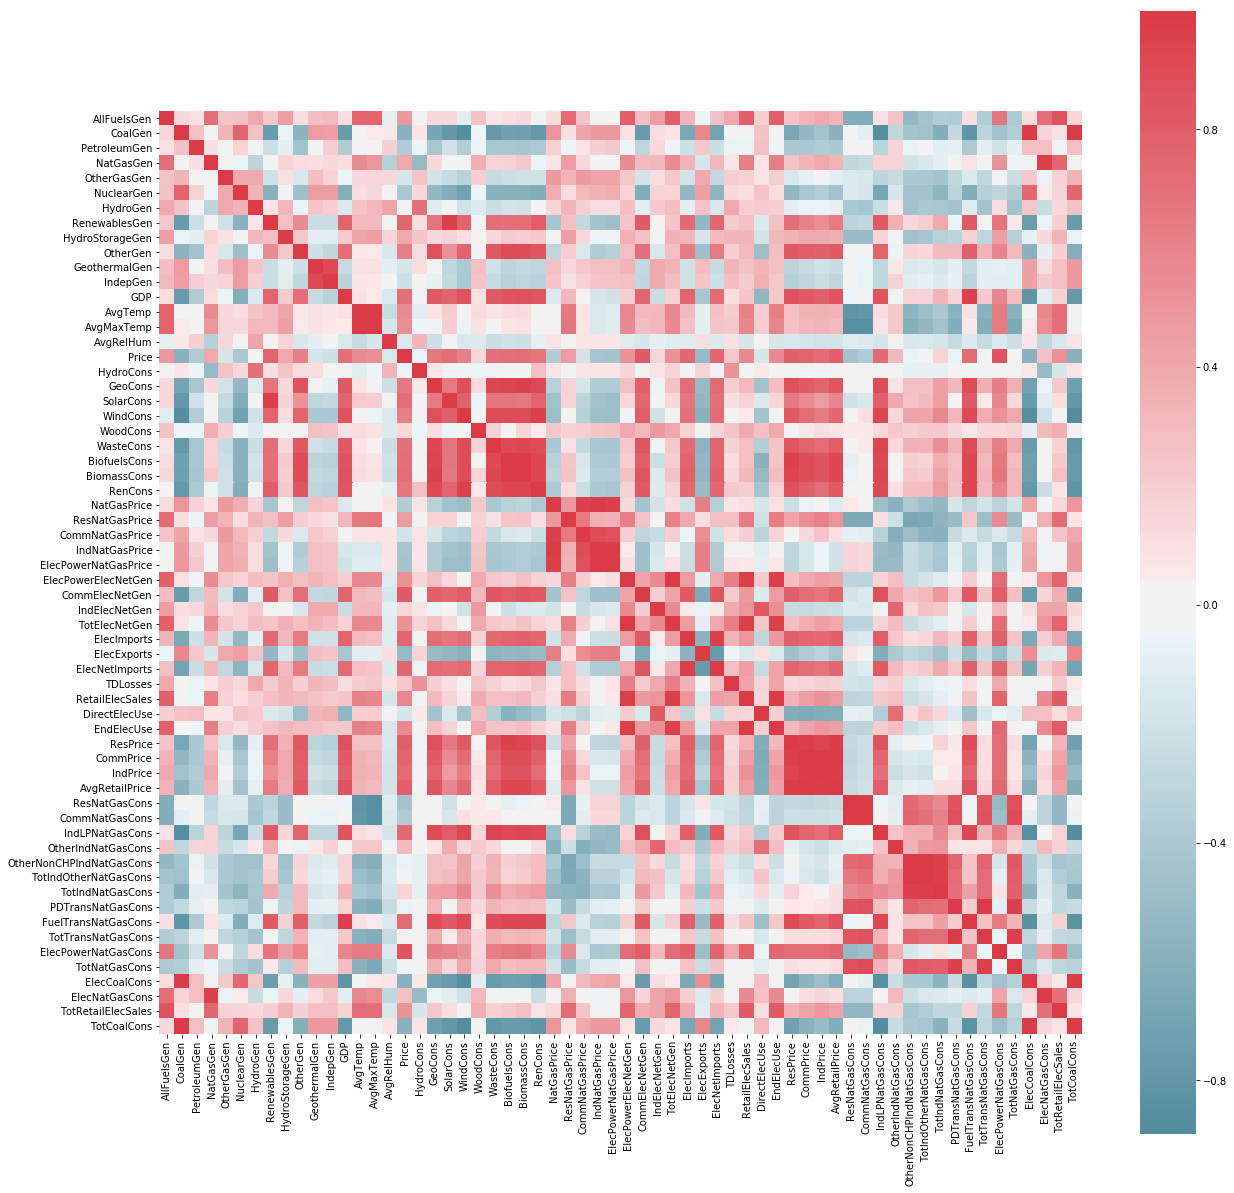

In [7]:
plt.close("all")
%run helper_functions.py
reg_heat_map(raw_all_data)

### Time displaced Pearson correlations of all features with price.

Displace (advance) feature signals by n months. This will line up past signals with future prices. Truncate n months at the end of feature signals and n months at the beginning of price signals.

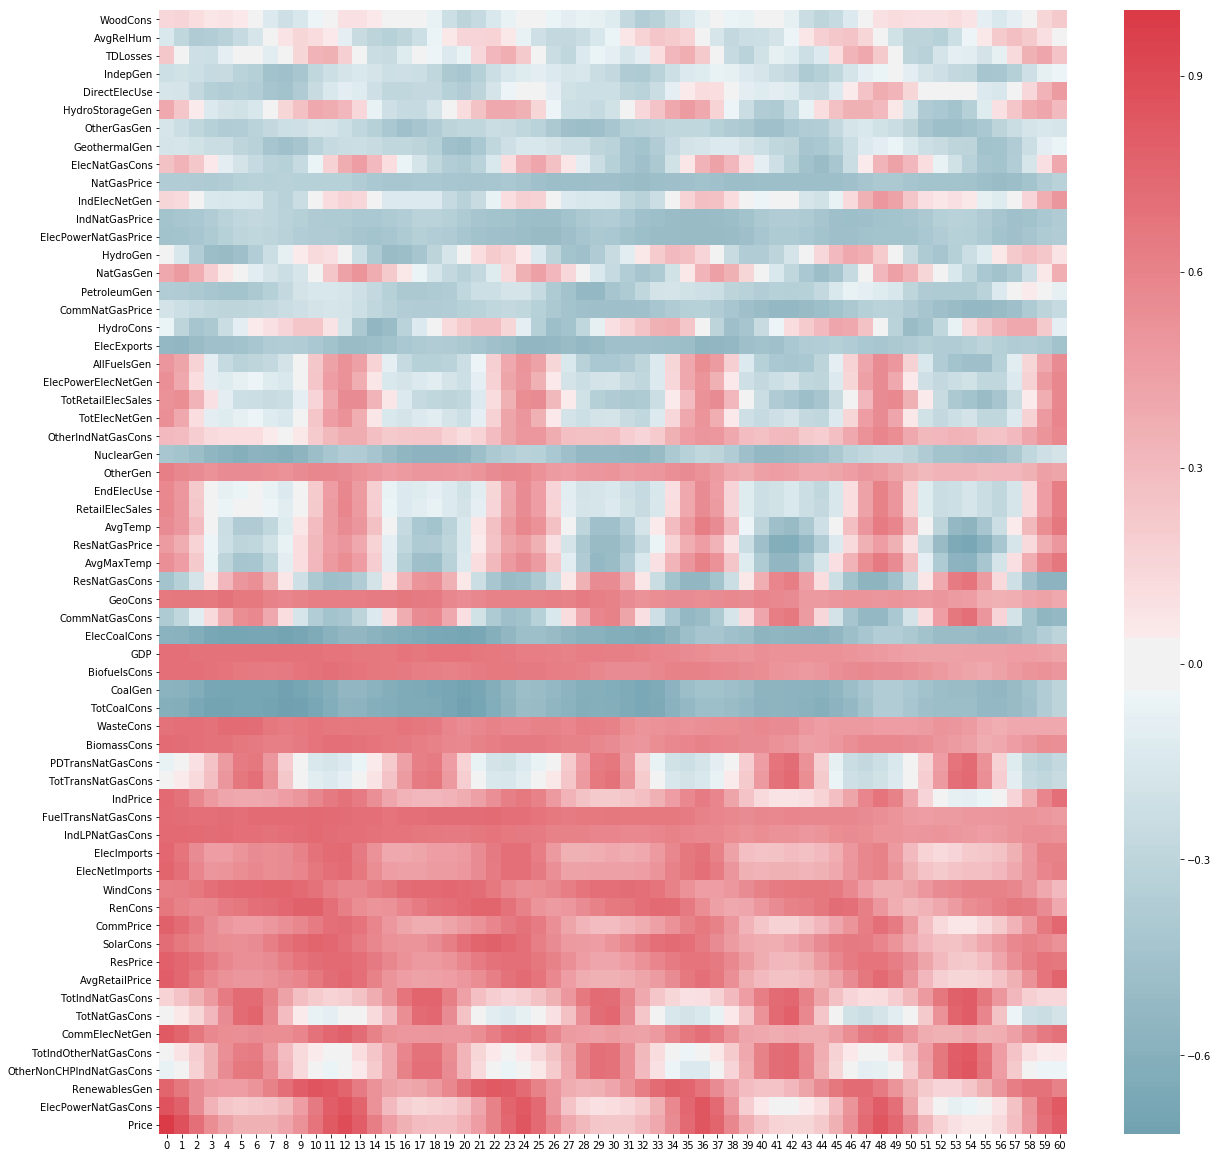

In [27]:
plt.close("all")
%run helper_functions.py 
time_heat_map(raw_all_data, months=60)

## Data Transformation

Standardize signals. Split data into a past to train on and a future to compare to.

In [8]:
%run helper_functions.py

pred_len = 60
start_back = 60
raw_test_data = raw_all_data.iloc[start_back:len(raw_all_data)]
raw_all_data.head()

AllFuelsGen  CoalGen  PetroleumGen  NatGasGen  OtherGasGen  NuclearGen  \
0     20980.32    23.13          3.45    9653.24       111.10     1648.01   
1     18260.49    26.83          3.31    7191.92       118.54      959.83   
2     16878.56    14.41          3.32    5243.69       136.91      840.14   
3     15436.07    19.34          3.53    4248.56       129.63     1412.87   
4     16101.85    27.06          0.00    4816.74       118.23     1569.14   

   HydroGen  RenewablesGen  HydroStorageGen  OtherGen     ...       \
0   4371.98        5008.54            79.49     81.38     ...        
1   4455.84        5388.18            38.33     77.71     ...        
2   4972.12        5532.79            66.09     69.08     ...        
3   4397.51        5155.79            -9.02     77.86     ...        
4   4481.18        5062.01           -50.84     74.80     ...        

   TotIndNatGasCons  PDTransNatGasCons  FuelTransNatGasCons  \
0            760.38              53.57                 3.69   
1            741.75              47.97                 3.56   
2            758.14              47.87                 3.68   
3            754.27              48.58                 3.56   
4            824.20              63.79                 3.68   

   TotTransNatGasCons  ElecPowerNatGasCons  TotNatGasCons  ElecCoalCons  \
0               57.27              1051.50        2111.26          5.42   
1               51.53               834.14        1890.42          6.16   
2               51.55               697.13        1886.70          3.57   
3               52.14               613.90        1914.40          4.53   
4               67.47               667.12        2513.84          6.22   

   ElecNatGasCons  TotRetailElecSales  TotCoalCons  
0        70676.53            24342.40        48.02  
1        52936.27            22235.31        55.52  
2        38705.09            19838.08        39.54  
3        30739.27            17875.54        43.50  
4        36072.47            19947.98        55.85  

[5 rows x 62 columns]

In [9]:
%run helper_functions.py

std_all_data, all_rescaler = standardize(raw_all_data, feature_range=[2,4], comp_var='Price')
std_test_data, test_rescaler1 = standardize(raw_test_data, feature_range=[2,4], comp_var='Price')
std_all_data.head()

AllFuelsGen   CoalGen  PetroleumGen  NatGasGen  OtherGasGen  NuclearGen  \
0     3.403972  2.077525      2.026144   3.129185     2.572144    2.660286   
1     2.963882  2.110420      2.025083   2.614948     2.658751    2.128649   
2     2.740275  2.000000      2.025159   2.207910     2.872592    2.036185   
3     2.506868  2.043830      2.026751   2.000000     2.787847    2.478634   
4     2.614597  2.112464      2.000000   2.118708     2.655142    2.599356   

   HydroGen  RenewablesGen  HydroStorageGen  OtherGen     ...       \
0  3.438962       3.739706         3.296057  3.789834     ...        
1  3.471293       3.928200         3.109403  3.693179     ...        
2  3.670338       4.000000         3.235290  3.465894     ...        
3  3.448804       3.812816         2.894678  3.697129     ...        
4  3.481062       3.766254         2.705031  3.616539     ...        

   TotIndNatGasCons  PDTransNatGasCons  FuelTransNatGasCons  \
0          3.312759           2.610458             3.992248   
1          3.190298           2.419690             3.891473   
2          3.298035           2.416283             3.984496   
3          3.272596           2.440470             3.891473   
4          3.732268           2.958610             3.984496   

   TotTransNatGasCons  ElecPowerNatGasCons  TotNatGasCons  ElecCoalCons  \
0            2.673360             3.755058       2.809354      2.037605   
1            2.481258             3.238610       2.568756      2.052648   
2            2.481928             2.913074       2.564703      2.000000   
3            2.501673             2.715319       2.594882      2.019514   
4            3.014726             2.841770       3.247952      2.053867   

   ElecNatGasCons  TotRetailElecSales  TotCoalCons  
0        3.025935            3.398367     2.173665  
1        2.570212            2.999104     2.286143  
2        2.204631            2.544863     2.046491  
3        2.000000            2.172989     2.105879  
4        2.137003            2.565687     2.291092  

[5 rows x 62 columns]

## Feature Construction

Create new features using derivatives (perhaps first interpolating with polynomials, then taking the derivative(s) of these instead of using finite difference), powers, time offsets, and perhaps products and quotients of these. Do this intelligently so as not to create an intractable amount of combinations.

In [10]:
%run helper_functions.py 
new_test_data0 = keep_distinct_features(std_test_data, 
                                        corr_cut=1, 
                                        look_back=0)

5 features thrown out due to correlation with other features. 0 NaNs resulted from Pearson calculations
56 total features remaining


In [11]:
new_test_data1 = trim_features(new_test_data0, corr_cut=.4, look_back=7)

15 features thrown out due to poor correlation with price at all month offsets from 0 to 7
41 total features remaining


In [12]:
%run helper_functions.py 
new_test_data2 = new_features_with_funcs(new_test_data1,
                                   [cumtrapz_ext, diff_ext, np.log, np.sqrt, np.square, np.exp, series_ma],
                                   ['Int', 'Diff', 'Log', 'Sqrt', 'Square', 'Exp', 'MA'],
#                                    [np.log, np.sqrt, np.square, np.exp],
#                                    ['Log', 'Sqrt', 'Square', 'Exp'],
                                   filter=True,
                                   corr_cut=0.75,
                                   look_back=7,
                                   exclude_comp_var=False)

15 net new features created with functions. 279 new features were thrown out due to poor correlation with price at all month offsets from 0 to 7
56 total features remaining


In [21]:
new_test_data2.shape

(139, 57)

In [22]:
%run helper_functions.py 
new_test_data3 = new_features_with_combs(new_test_data2, 
                                         combiners=['*','/'],#,'+','-'],
                                         n_combiners=5,
                                         filter=True, 
                                         corr_cut=0.85, 
                                         look_back=7,
                                         exclude_comp_var=False)

280 net new features created with combinations. 7700 new features were thrown out due to poor correlation with Price
336 total features remaining


In [23]:
%run helper_functions.py 
new_test_data4 = keep_distinct_features(new_test_data3, 
                                        corr_cut=.95, 
                                        look_back=0)

258 features thrown out due to correlation with other features. 0 NaNs resulted from Pearson calculations
78 total features remaining


In [24]:
%run helper_functions.py 
new_test_data5 = trim_features(new_test_data4, corr_cut=.7, look_back=12)
new_test_data = new_test_data5

29 features thrown out due to poor correlation with price at all month offsets from 0 to 12
49 total features remaining


In [25]:
# %run helper_functions.py 
# new_test_data5 = new_features_with_funcs(new_test_data4,\
#                                    [cumtrapz_ext, diff_ext, np.log, np.sqrt, np.square, np.exp],\
#                                    ['Int', 'Diff', 'Log', 'Sqrt', 'Square', 'Exp'],\
#                                    filter=True,\
#                                    corr_cut=0.8,\
#                                    look_back=7)

In [26]:
# %run helper_functions.py 
# new_test_data6 = new_features_with_combs(new_test_data5, combiners=['*','/'], filter=True, corr_cut=0.7, look_back=7)

In [27]:
# %run helper_functions.py 
# new_test_data7 = keep_distinct_features(new_test_data6, corr_cut=.9, look_back=7)

In [28]:
# %run helper_functions.py 
# new_test_data8 = trim_features(new_test_data7, corr_cut=.75, look_back=48)

In [29]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=10)
# new_vals = pca.fit_transform(new_test_data4.drop('Price',axis=1).replace([np.inf, -np.inf], np.nan).dropna(1).values)
# new_test_data_PCA = pd.DataFrame(data=new_vals, columns = [str(i) for i in range(10)])
# new_test_data_PCA = pd.concat([new_test_data2.Price, new_test_data_PCA], axis=1)
# new_test_data_PCA 

## New Correlation Matrices

Pearson correlation matrix "heat map" for colinearity between all features (old and new).

Time displaced correlation matrix "heat map" for colinearity between all features (old and new) and electricity price at offset times.

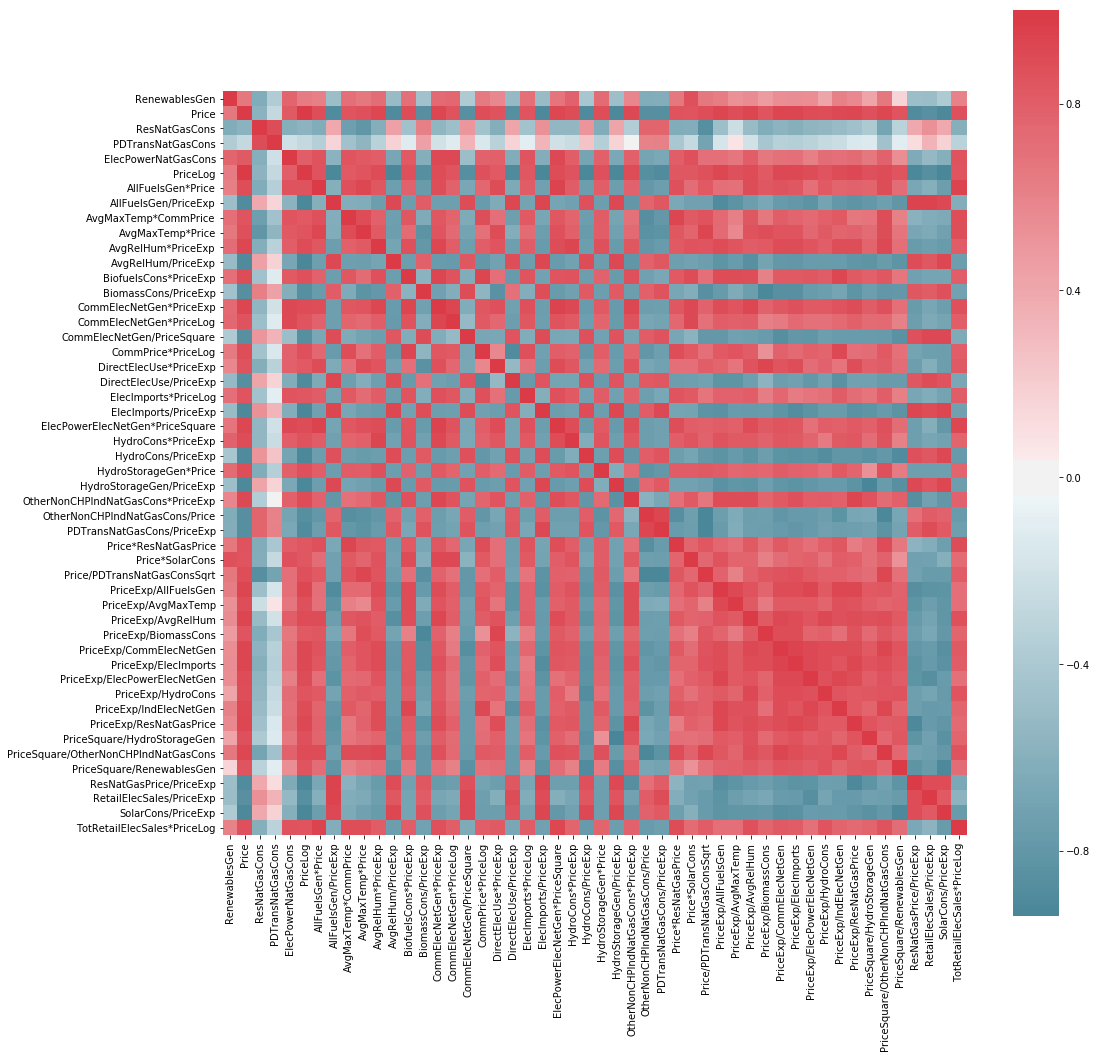

In [30]:
plt.close("all")
%run helper_functions.py 
plot = reg_heat_map(new_test_data)

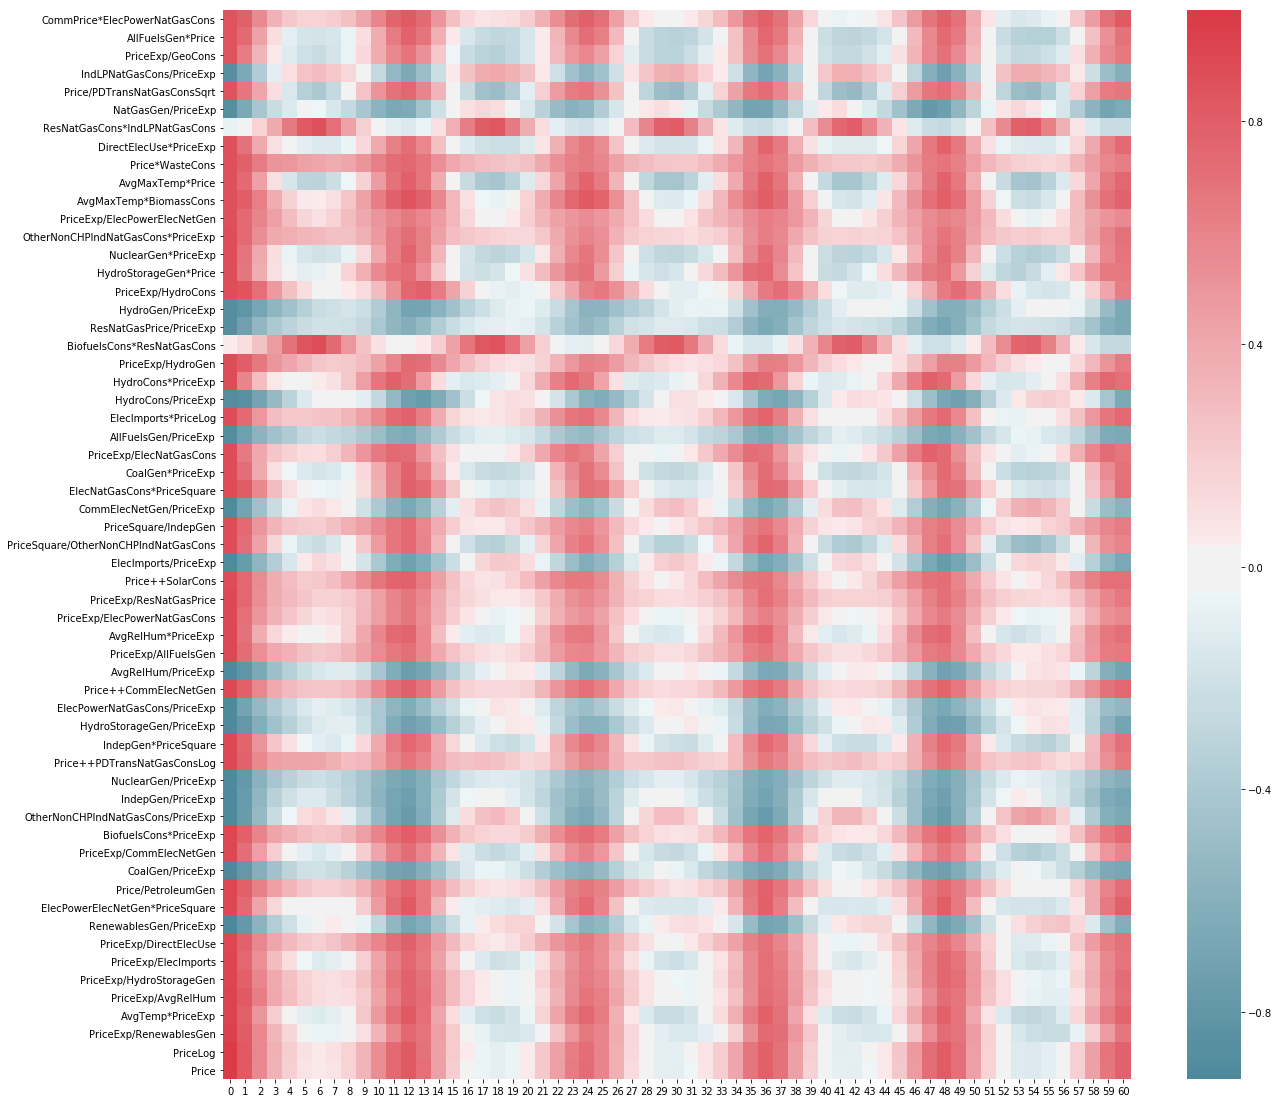

In [42]:
plt.close("all")
%run helper_functions.py 
time_heatmap = time_heat_map(new_test_data,months=60)

In [31]:
plt.close("all")
%run helper_functions.py 
signal_plot(new_test_data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [32]:
new_test_data.shape

(139, 50)

In [50]:
#new_test_data.to_csv('EPPdf6', sep='\t')

In [22]:
# %run helper_functions.py 
# slid = slide_df(new_data, 40, 24, purpose = 'train')
# slid.head()

In [23]:
# reg_heat_map(slid)

In [24]:
# new_test_data.head()

In [25]:
# %run helper_functions.py 
# sample_train_slid_df = slide_df(new_test_data, 60, 60, purpose='train')
# sample_train_slid_df

In [33]:
%run helper_functions.py 
sample_test_slid_df = slide_df(new_test_data, 1, 113, purpose='train')
sample_test_slid_df.head()

Price  RenewablesGen-1   Price-1  ResNatGasCons-1  PDTransNatGasCons-1  \
0  3.718266         4.000000  3.845201         2.037419             2.744998   
1  3.845201         3.921140  3.287926         2.128816             2.746275   
2  3.287926         3.069203  3.133127         2.395902             2.853555   
3  3.133127         3.164623  3.114551         2.680949             3.073648   
4  3.114551         2.755503  3.160991         3.276411             3.564496   

   ElecPowerNatGasCons-1  PriceLog-1  AllFuelsGen*Price-1  \
0               3.475034    1.346826            10.078564   
1               3.299681    1.190257             8.387352   
2               3.044417    1.142032             7.237705   
3               2.939741    1.136085             7.447283   
4               2.862821    1.150885             7.348866   

   AllFuelsGen/PriceExp-1  AvgMaxTemp*CommPrice-1  \
0                0.056044               12.225819   
1                0.095230               10.907338   
2                0.100675                9.527317   
3                0.106162                8.224207   
4                0.098536                8.321112   

                ...                 PriceExp/HydroCons-113  \
0               ...                               6.959097   
1               ...                               6.446939   
2               ...                               6.987945   
3               ...                               7.959155   
4               ...                              10.798600   

   PriceExp/IndElecNetGen-113  PriceExp/ResNatGasPrice-113  \
0                    6.040125                     8.283559   
1                    4.409118                     8.172562   
2                    5.928330                     9.507247   
3                    6.536476                     9.877091   
4                    7.846447                    11.372292   

   PriceSquare/HydroStorageGen-113  PriceSquare/OtherNonCHPIndNatGasCons-113  \
0                         3.452675                                  2.277720   
1                         4.118361                                  2.059181   
2                         3.242974                                  2.353515   
3                         3.437334                                  2.618458   
4                         3.595572                                  3.103365   

   PriceSquare/RenewablesGen-113  ResNatGasPrice/PriceExp-113  \
0                       3.765420                     0.120721   
1                       3.497350                     0.122361   
2                       3.844654                     0.105183   
3                       4.003568                     0.101244   
4                       4.092307                     0.087933   

   RetailElecSales/PriceExp-113  SolarCons/PriceExp-113  \
0                      0.135429                0.111663   
1                      0.161726                0.114052   
2                      0.127289                0.104789   
3                      0.103020                0.103034   
4                      0.099727                0.090717   

   TotRetailElecSales*PriceLog-113  
0                         2.207381  
1                         2.711288  
2                         2.625983  
3                         2.227947  
4                         3.229503  

[5 rows x 5651 columns]

In [34]:
# %run helper_functions.py 
# new_test_data_wma = df_add_moving_averages(new_test_data, window=12)
# new_test_data_wma.head()

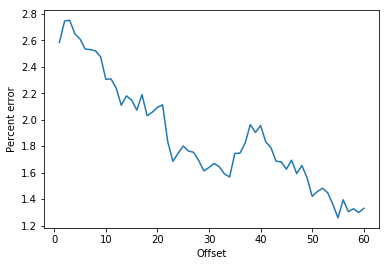

len_data_mean  n_iter_mean  \
offset look_back train_prop neg_alpha                               
1      12        0.3        -0.0001            12727          282   
2      12        0.3        -0.0001            12626          341   
3      12        0.3        -0.0001            12525          317   
4      12        0.3        -0.0001            12424          329   
5      12        0.3        -0.0001            12323          355   

                                       num_feats_mean  pred_mean  \
offset look_back train_prop neg_alpha                              
1      12        0.3        -0.0001                24   3.733190   
2      12        0.3        -0.0001                19   3.629818   
3      12        0.3        -0.0001                20   3.387282   
4      12        0.3        -0.0001                22   3.217738   
5      12        0.3        -0.0001                27   3.122222   

                                       test_error_mean  test_num_mean  \
offset look_back train_prop neg_alpha                                   
1      12        0.3        -0.0001           2.584273           8909   
2      12        0.3        -0.0001           2.745287           8839   
3      12        0.3        -0.0001           2.751261           8768   
4      12        0.3        -0.0001           2.648093           8697   
5      12        0.3        -0.0001           2.609275           8627   

                                       train_error_mean  train_num_mean  \
offset look_back train_prop neg_alpha                                     
1      12        0.3        -0.0001            2.572390            3818   
2      12        0.3        -0.0001            2.629010            3787   
3      12        0.3        -0.0001            2.723703            3757   
4      12        0.3        -0.0001            2.667063            3727   
5      12        0.3        -0.0001            2.523848            3696   

                                       len_data_std  n_iter_std  \
offset look_back train_prop neg_alpha                             
1      12        0.3        -0.0001             NaN         NaN   
2      12        0.3        -0.0001             NaN         NaN   
3      12        0.3        -0.0001             NaN         NaN   
4      12        0.3        -0.0001             NaN         NaN   
5      12        0.3        -0.0001             NaN         NaN   

                                             ...         train_num_std  \
offset look_back train_prop neg_alpha        ...                         
1      12        0.3        -0.0001          ...                   NaN   
2      12        0.3        -0.0001          ...                   NaN   
3      12        0.3        -0.0001          ...                   NaN   
4      12        0.3        -0.0001          ...                   NaN   
5      12        0.3        -0.0001          ...                   NaN   

                                                                       kept_feats_sample  \
offset look_back train_prop neg_alpha                                                      
1      12        0.3        -0.0001    RenewablesGen-1+AvgRelHum*PriceExp-1+CommElecN...   
2      12        0.3        -0.0001    RenewablesGen-2+HydroCons*PriceExp-2+HydroStor...   
3      12        0.3        -0.0001    RenewablesGen-3+HydroStorageGen*Price-3+PDTran...   
4      12        0.3        -0.0001    CommElecNetGen*PriceLog-4+HydroStorageGen*Pric...   
5      12        0.3        -0.0001    AvgMaxTemp*CommPrice-5+PDTransNatGasCons-6+Hyd...   

                                       len_data_sample  n_iter_sample  \
offset look_back train_prop neg_alpha                                   
1      12        0.3        -0.0001              12727            282   
2      12        0.3        -0.0001              12626            341   
3      12        0.3        -0.0001              12525            317   
4      12        0.3        -0.0001      

In [35]:
%run helper_functions.py 
plt.close("all")

best_hps, full_df = \
    train_hopping_lasso(new_test_data, comp_var='Price', interp=100,
                        pred_len=pred_len, iter=1, 
                        look_back_step=12, look_back_override='single', 
                        test_props=list(np.linspace(.3,.7,3)),  #change linspace from 5 component to 3 
#                         test_props = [.15,2], 
                        model_type=Lasso,
                        minmax_alpha = [.0001,.0005],
                        n_alphas=1)
best_df = full_df.loc[list(best_hps),:]
preds = test_rescaler1(best_df.pred_mean.values)
preds2 = test_rescaler1(full_df.groupby('offset').mean().pred_mean)
preds_max = test_rescaler1(best_df.pred_mean.values+best_df.pred_std.values)
preds_min = test_rescaler1(best_df.pred_mean.values-best_df.pred_std.values)
best_df.head()

In [36]:
#pd.DataFrame(best_hps).to_csv('best_hps_for_EPPdf6', sep='\t')
#full_df.to_csv('full_df_for_EPPdf6', sep='\t')

In [37]:
# %run helper_functions.py 
# full_df.head()

In [38]:
# print([df['alpha'].values[0] for df in training_dfs])
# plt.plot([df['alpha'].values[0] for df in training_dfs])
# plt.show()

In [39]:
# x = np.linspace(0,5)
# plt.plot(x,all_rescaler(x),label='all_rescaler')
# plt.plot(x,test_rescaler1(x),label='test_rescaler')
# plt.legend()
# plt.show()

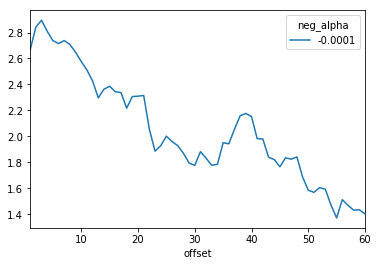

In [40]:
full_df.groupby(['offset','neg_alpha']).mean().test_error_mean.unstack('neg_alpha').plot()
plt.show()

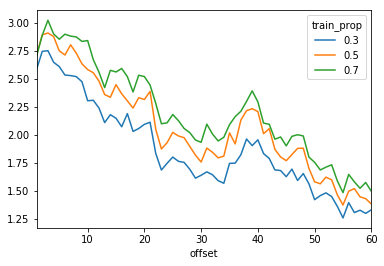

In [41]:
full_df.groupby(['offset','train_prop']).mean().test_error_mean.unstack('train_prop').plot()
plt.show()

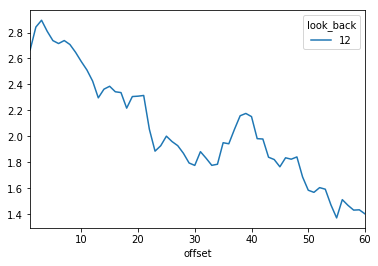

In [42]:
full_df.groupby(['offset','look_back']).mean().test_error_mean.unstack('look_back').plot()
plt.show()

In [43]:
# for index in best_df.index:
#     print(str(index)+': '+best_df.loc[index].kept_feats_sample)

In [44]:
# full_df.groupby('offset').mean()

In [45]:
preds2 = test_rescaler1(full_df.groupby('offset').mean().pred_mean)

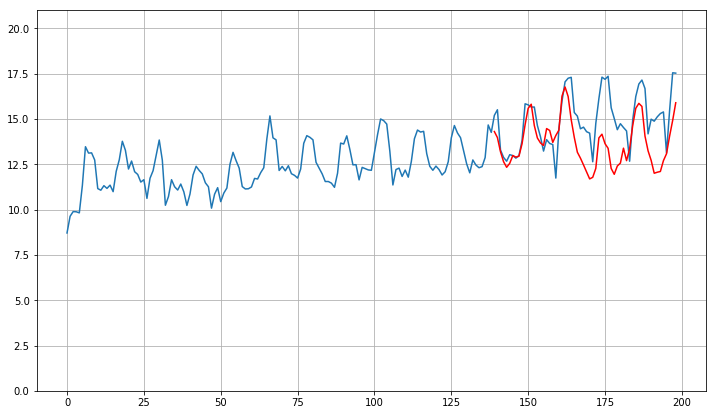

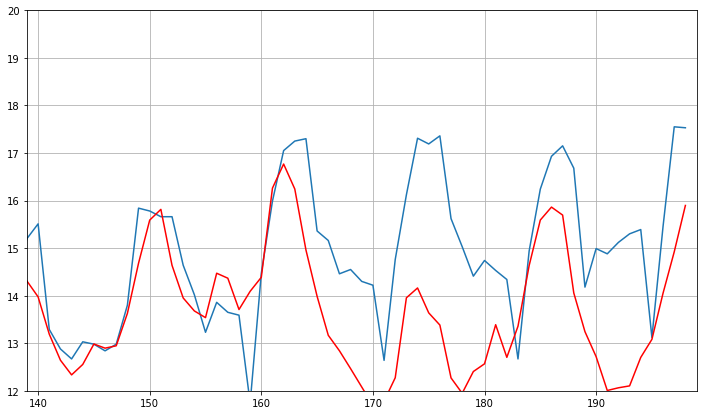

Test RMSE: 1.784616420274227


In [46]:
%run helper_functions.py

plt.close("all")
plt.figure(figsize=(12,7))
plt.plot(range(len(std_all_data)), all_rescaler(flip_df(std_all_data).Price))
plt.plot(range(len(std_all_data)-start_back, len(std_all_data)+pred_len-start_back),[pred for pred in preds], 'r')
# plt.plot(range(len(std_all_data)-start_back, len(std_all_data)+pred_len-start_back),[pred for pred in preds2], 'g')
# plt.plot(range(len(std_all_data)-pred_len, len(std_all_data)),[pred for pred in preds_max], '--r', linewidth=1)
# plt.plot(range(len(std_all_data)-pred_len, len(std_all_data)),[pred for pred in preds_min], '--r', linewidth=1)
plt.ylim([0,21])
# plt.xlim([len(std_all_data)-len(preds), len(std_all_data)])
plt.grid()
plt.show()

plt.figure(figsize=(12,7))
plt.plot(range(len(std_all_data)), all_rescaler(flip_df(std_all_data).Price))
# plt.plot(range(len(std_all_data)-pred_len, len(std_all_data)),[pred for pred in preds], '+r')
plt.plot(range(len(std_all_data)-start_back, len(std_all_data)+pred_len-start_back),[pred for pred in preds], 'r')
# plt.plot(range(len(std_all_data)-start_back, len(std_all_data)+pred_len-start_back),[pred for pred in preds2], 'g')
#plt.plot(range(len(std_all_data)-start_back, len(std_all_data)+pred_len-start_back),[pred for pred in preds_max], '--r', linewidth=1)
#plt.plot(range(len(std_all_data)-start_back, len(std_all_data)+pred_len-start_back),[pred for pred in preds_min], '--r', linewidth=1)
plt.ylim([12,20])
plt.xlim([len(std_all_data)-len(preds), len(std_all_data)])
plt.grid()
plt.show()

# The mean squared error 
RMSE = math.sqrt(mean_squared_error(all_rescaler(flip_df(std_all_data).Price)[-len(preds2):], preds)) 
print("Test RMSE:", RMSE)

(60,)

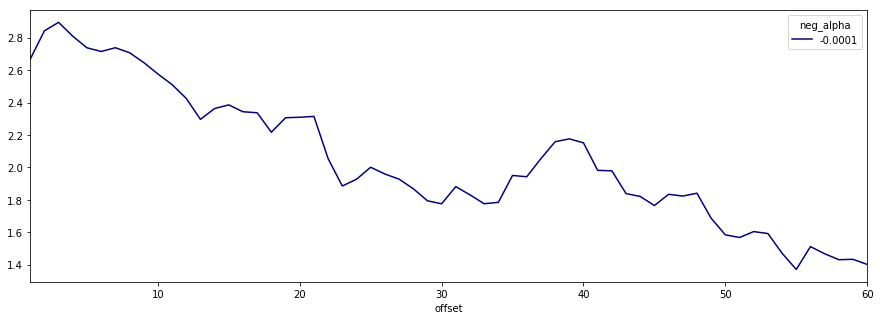

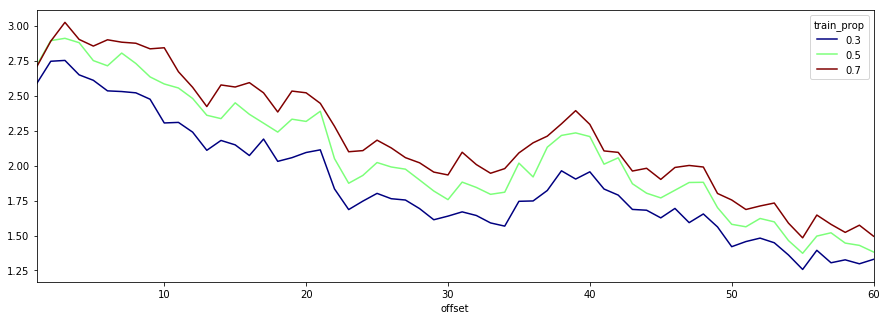

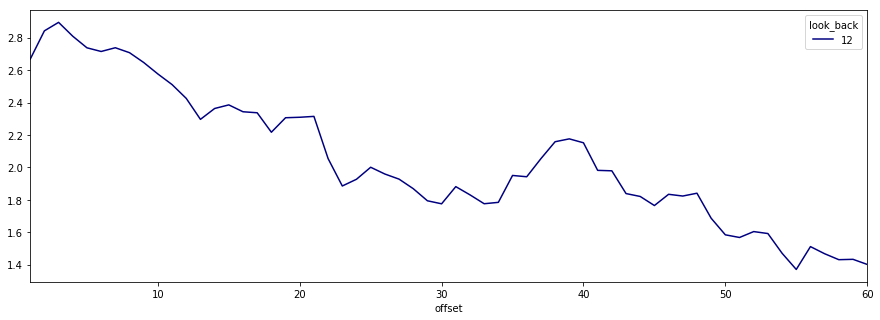

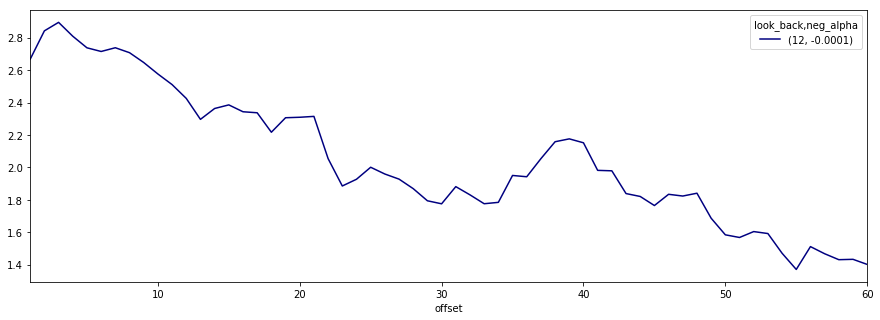

In [47]:
full_df.groupby(['offset','neg_alpha']).mean().test_error_mean.unstack('neg_alpha').plot(figsize=[15,5],colormap='jet')
plt.show()
full_df.groupby(['offset','train_prop']).mean().test_error_mean.unstack('train_prop').plot(figsize=[15,5],colormap='jet')
plt.show()
full_df.groupby(['offset','look_back']).mean().test_error_mean.unstack('look_back').plot(figsize=[15,5],colormap='jet')
plt.show()
full_df.groupby(['offset','look_back','neg_alpha']).mean().test_error_mean.unstack(['look_back','neg_alpha']).plot(figsize=[15,5],colormap='jet')
plt.show()

In [48]:
# %run helper_functions.py
# len_gif = 60
# filenames = ['figs/offset'+str(i)+'.jpg' for i in range(len_gif)]
# for g in range(2):
#     for f in range(len_gif):
#         df = slide_df(new_test_data,f,11)
#         if g == 0: sort=True
#         else: sort=False
#         time_heat_map(df, show=False, sort=sort, months=0, include_cbar=False)\
#         .get_figure().savefig(filenames[f],bbox_inches='tight')
#     import imageio
#     images = []
#     for filename in filenames:
#         images.append(imageio.imread(filename))
#     imageio.mimsave('gifs/gif'+str(g)+'.gif', images)

In [49]:
z = zip(['offset']*12, [str(i) for i in range(12)])

In [50]:
filenames = ['offset'+str(i)+'.png' for i in range(48)]
# filenames

In [51]:
# import imageio
# images = []
# for filename in filenames:
#     images.append(imageio.imread(filename))
# imageio.mimsave('movie.gif', images)

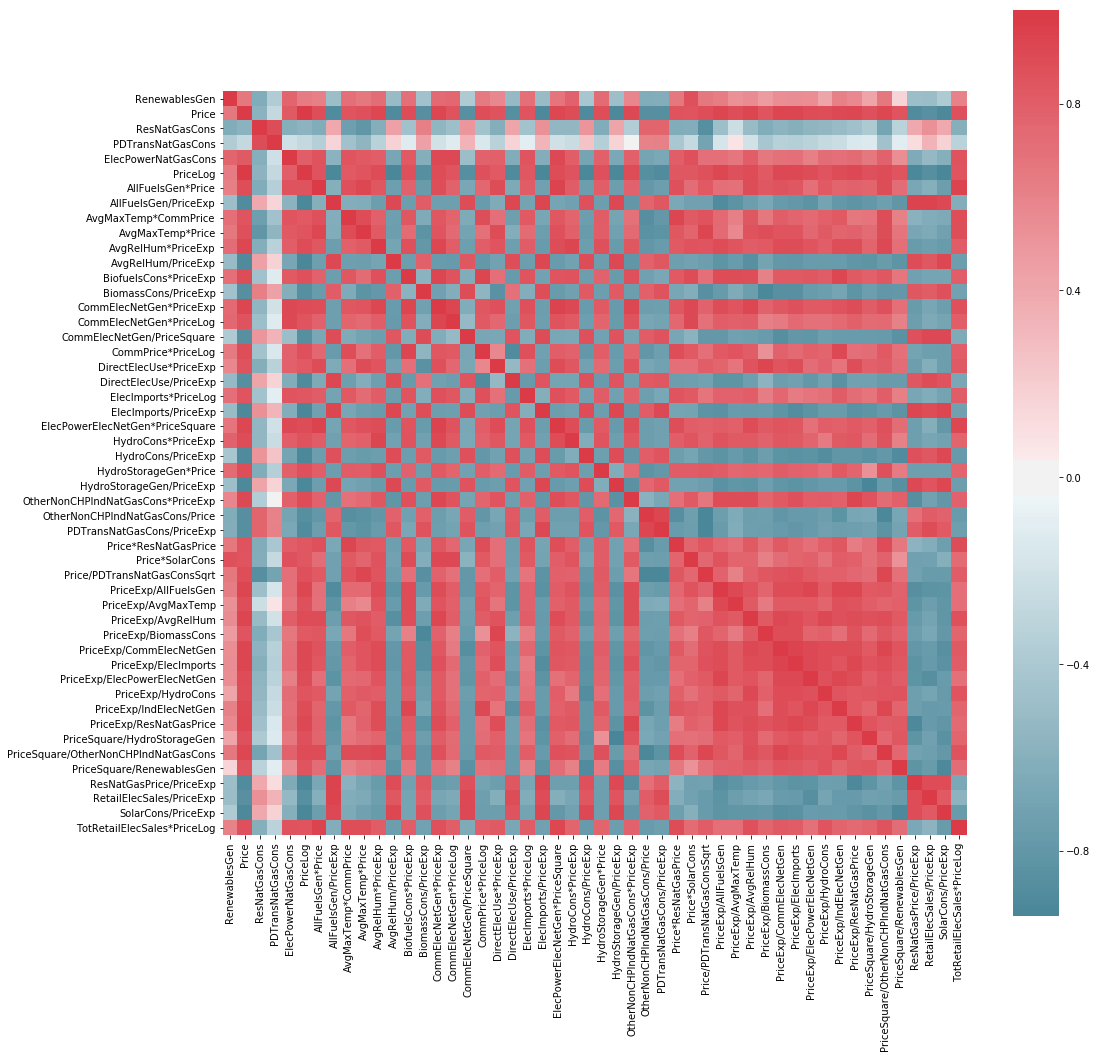

In [52]:
%run helper_functions.py
reg_heat_map(new_test_data)

In [53]:
# %run helper_functions.py
# plt.close('all')
# time_heat_map(df, show=True, sort=False, include_cbar=False, months=0)

In [54]:
df = new_test_data
new_test_data.head()

RenewablesGen     Price  ResNatGasCons  PDTransNatGasCons  \
0       3.632363  3.718266       2.001035           2.995743   
1       4.000000  3.845201       2.037419           2.744998   
2       3.921140  3.287926       2.128816           2.746275   
3       3.069203  3.133127       2.395902           2.853555   
4       3.164623  3.114551       2.680949           3.073648   

   ElecPowerNatGasCons  PriceLog  AllFuelsGen*Price  AllFuelsGen/PriceExp  \
0             4.000000  1.313257          11.024952              0.071980   
1             3.475034  1.346826          10.078564              0.056044   
2             3.299681  1.190257           8.387352              0.095230   
3             3.044417  1.142032           7.237705              0.100675   
4             2.939741  1.136085           7.447283              0.106162   

   AvgMaxTemp*CommPrice  AvgMaxTemp*Price             ...               \
0             13.326783         13.646440             ...                
1             12.225819         12.946447             ...                
2             10.907338         10.523681             ...                
3              9.527317          8.950439             ...                
4              8.224207          7.656572             ...                

   PriceExp/HydroCons  PriceExp/IndElecNetGen  PriceExp/ResNatGasPrice  \
0           12.694971               11.342159                12.974819   
1           14.330454               15.161915                15.405298   
2            7.687814                8.826616                 9.545922   
3            7.119473                8.751554                 8.956784   
4            7.082830                7.818975                 9.066365   

   PriceSquare/HydroStorageGen  PriceSquare/OtherNonCHPIndNatGasCons  \
0                     4.288310                              4.785157   
1                     4.540308                              5.114851   
2                     3.137700                              3.579274   
3                     3.067817                              3.168712   
4                     3.020119                              2.873457   

   PriceSquare/RenewablesGen  ResNatGasPrice/PriceExp  \
0                   3.806201                 0.077072   
1                   3.696393                 0.064913   
2                   2.756967                 0.104757   
3                   3.198383                 0.111647   
4                   3.065271                 0.110298   

   RetailElecSales/PriceExp  SolarCons/PriceExp  TotRetailElecSales*PriceLog  
0                  0.096132            0.097104                     4.212000  
1                  0.068409            0.084301                     3.983105  
2                  0.101959            0.143326                     3.201152  
3                  0.100060            0.152128                     2.713623  
4                  0.111499            0.143578                     2.964319  

[5 rows x 50 columns]

In [55]:
%run helper_functions.py
df_int = df_interpolate(new_test_data,1)
df_int.head()

RenewablesGen     Price  ResNatGasCons  PDTransNatGasCons  \
0       3.632363  3.718266       2.001035           2.995743   
1       3.800120  3.958438       2.027737           2.828515   
2       4.000000  3.845201       2.037419           2.744998   
3       4.088255  3.560912       2.060854           2.724486   
4       3.921140  3.287926       2.128816           2.746275   

   ElecPowerNatGasCons  PriceLog  AllFuelsGen*Price  AllFuelsGen/PriceExp  \
0             4.000000  1.313257          11.024952              0.071980   
1             3.654025  1.378685          10.717439              0.049283   
2             3.475034  1.346826          10.078564              0.056044   
3             3.383446  1.267433           9.253483              0.076586   
4             3.299681  1.190257           8.387352              0.095230   

   AvgMaxTemp*CommPrice  AvgMaxTemp*Price             ...               \
0             13.326783         13.646440             ...                
1             12.820910         13.733357             ...                
2             12.225819         12.946447             ...                
3             11.576349         11.728843             ...                
4             10.907338         10.523681             ...                

   PriceExp/HydroCons  PriceExp/IndElecNetGen  PriceExp/ResNatGasPrice  \
0           12.694971               11.342159                12.974819   
1           15.818534               15.987363                16.398647   
2           14.330454               15.161915                15.405298   
3           10.772843               11.797702                12.339485   
4            7.687814                8.826616                 9.545922   

   PriceSquare/HydroStorageGen  PriceSquare/OtherNonCHPIndNatGasCons  \
0                     4.288310                              4.785157   
1                     4.885212                              5.442677   
2                     4.540308                              5.114851   
3                     3.781752                              4.320707   
4                     3.137700                              3.579274   

   PriceSquare/RenewablesGen  ResNatGasPrice/PriceExp  \
0                   3.806201                 0.077072   
1                   4.079637                 0.057228   
2                   3.696393                 0.064913   
3                   3.105745                 0.085599   
4                   2.756967                 0.104757   

   RetailElecSales/PriceExp  SolarCons/PriceExp  TotRetailElecSales*PriceLog  
0                  0.096132            0.097104                     4.212000  
1                  0.065731            0.071317                     4.215397  
2                  0.068409            0.084301                     3.983105  
3                  0.086406            0.115242                     3.612549  
4                  0.101959            0.143326                     3.201152  

[5 rows x 50 columns]

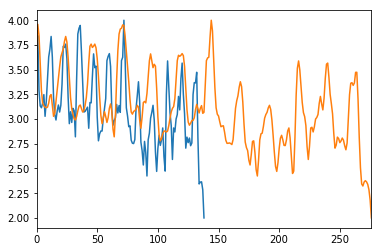

In [56]:
df.Price.plot()
df_int.Price.plot()
plt.show()

In [57]:
df.index

RangeIndex(start=0, stop=139, step=1)

In [58]:
fillers = [str(num) for num in np.arange(1,n+1)]
new_index = []
for i in df.index:
    new_index.append(i)
    for new in fillers:
        new_index.append(str(i)+new)
df_nans = df.reindex(index=new_index).reset_index(drop=True)
return df_nans.interpolate(method=method, order=3).dropna()

NameError: name 'n' is not defined

### Compare to docket

Next we compare to the performance of the following datasets: 
- raw_data (before nonlinearities), 199,97        (EPPdf1)
- std_all_data (before nonlinearities), 199,97    (EPPdf2)
- new_test_data (JS)(nonlinearities)              (EPPdf3)
- sample_train_ slid_df (new_test_data with sliding),(EPPdf4)  79 rows × 3181 columns, cuts 60 off beginning
- all_ slid_df (std_all_data but with sliding),   (EPPdf5)     80 rows × 5821 columns, cuts 60 off beginning
- new_test_data (EY)(nonlinearities),             (EPPdf6)
- RFE new_test_data (10,25,40 features),            (EPPdf7)
- PCA new_test_data (2,15,20 dimensions),            (EPPdf8)
- old test data,                                  (EPPdf9)  Retail Average Data Set.csv 199 x 10
- old test data with ARIMA projections,           (EPPdf10) 199 x 5

Note that all of these do not use a slid_df and thus assume we have perfect knowledge of the other signals in the future (except the ARIMA projections). This is of course impossible but provides a theoretical upper bound for model performance. Also note that the original dataframe for all of (----) is FINAL DATA_18 Apr_no0, which is the final dataset but with 4 zeros turned to 0.1s and all columns with NaNs after 2016 removed.

All of these datasets except EPPdf6 were made in the EPPdfMaker notebook and saved as csvs for later use.

All dfs were tested on the following models, known as the docket: 
- Linear Regression, 
- baysian ridge regression, 
- SVR, 
- KNN, 
- Random Forrest regression, 
- Bagging, 
- Multi Layer Perceptron.
- Last year's simple SARIMA price projection

In [179]:
#Run docket on each of the dataframes, loop through whole docket for each df and looping through to hit each df
#Plot timeseries graph of each docket run, make one 3x3 tiled plot for each EPPdf
#Plot a bar chart comparing RMSEs of all model and EPPdf combinations
#total output should be 160 plots (16 dfs, 9 timeseries, 1 RMSE bars)

In [122]:
#initialize RMSE df
RMSE_df = pd.DataFrame({'new_model':[RMSE,0]})
RMSE_df

new_model
0   1.784616
1   0.000000

Lag: 13
Coefficients: [ 1.06677311  0.71667487 -0.04742529  0.00996292 -0.10742766  0.03398829
  0.00385755  0.08223125 -0.11279282  0.00708117  0.02652485  0.26545579
  0.28168885 -0.24237987]
Test RMSE: 2.230


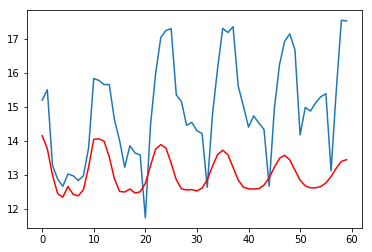

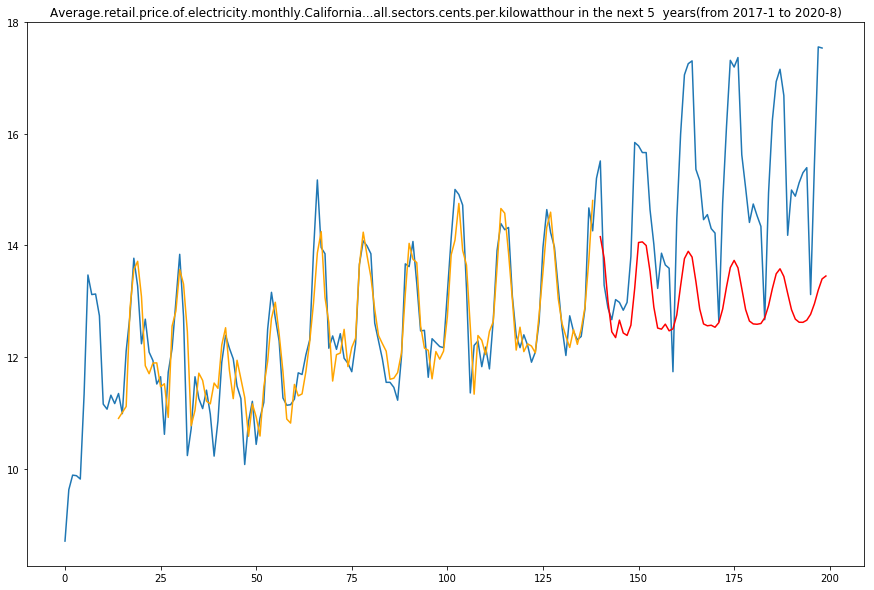

Train RMSE: 0.512
Test RMSE: 2.230


In [123]:
#Store the baselines
#Last year's simple S-ARIMA price projection
# use time series predict retail price directly ***5 years

from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt

old_data = pd.read_csv('Retail Average Data Set.csv')
old_data = old_data.drop('Month',axis=1)

#series = Series.from_csv('Average.retail.price.of.electricity.monthly.California...all.sectors.cents.per.kilowatthour.csv', header=0)
series = old_data['Average.retail.price.of.electricity.monthly.California...all.sectors.cents.per.kilowatthour']
# split dataset
X = series.values
train, test = X[0:len(X)-12*5], X[len(X)-12*5:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
#for i in range(len(predictions)):
#    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
test_error = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % test_error)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()
#RMSE_df.iloc[1]['old_1feat_method']=[test_error]


# print the predicted data (the bule one is the real data, the red one is the predicted data)
predictions = model_fit.predict(start=model_fit.k_ar+1, end=len(train)+len(test)-1, dynamic=False)
plt.figure(figsize=(15,10))
pyplot.plot(X)
#pyplot.plot(X[len(train):])
pyplot.plot(np.arange(len(test))+len(train)+1,predictions[-60:], color='red')
pyplot.plot(np.arange(len(predictions[0:-60]))+model_fit.k_ar+1,predictions[0:-60], color='orange')
pyplot.title('Average.retail.price.of.electricity.monthly.California...all.sectors.cents.per.kilowatthour in the next 5  years(from 2017-1 to 2020-8)')
pyplot.show()
train_error = sqrt(mean_squared_error(train[model_fit.k_ar+1:], predictions[0:-60]))
print('Train RMSE: %.3f' % train_error)
print('Test RMSE: %.3f' % test_error)
RMSE_df['old_1feat_method']=[train_error,test_error]


In [124]:
####Run the docket

#read in the EPPdfs
EPPdf1 = pd.read_csv('EPPdf1.csv') #price, len 199
EPPdf2 = pd.read_csv('EPPdf2.csv') #scaled price, len 199
EPPdf3 = pd.read_csv('EPPdf3.csv') #scaled price, len 139
EPPdf4= flip_df(pd.read_csv('EPPdf4.csv')) #truncated head,scaled price, len 79
EPPdf5 = flip_df(pd.read_csv('EPPdf5.csv')) #truncated head, scaled price, len 80
EPPdf6 = flip_df(pd.read_csv('EPPdf6.csv')) #separate scaling, use internal rescaler len 163 (missing last 3 months) use test_rescaler1
EPPdf7_10 = pd.read_csv('EPPdf7_10.csv') #scaled price, len 139
EPPdf7_25 = pd.read_csv('EPPdf7_25.csv') #scaled price, len 139
EPPdf7_40 = pd.read_csv('EPPdf7_40.csv') #scaled price, len 139
EPPdf8_2 = pd.read_csv('EPPdf8_2.csv') #scaled price, len 121
EPPdf8_15 = pd.read_csv('EPPdf8_15.csv') #scaled price, len 121
EPPdf8_20 = pd.read_csv('EPPdf8_20.csv') #scaled price, len 121
EPPdf9 = pd.read_csv('EPPdf9.csv') #price, len 199
EPPdf10 = pd.read_csv('EPPdf10.csv') #price, len 199

#Rename target variable column to 'Price' in 9 and 10
EPPdf9 = EPPdf9.rename(index=str, columns={'Average.retail.price.of.electricity.monthly.California...all.sectors.cents.per.kilowatthour': "Price"} )
EPPdf10 = EPPdf10.rename(index=str, columns={'Average.retail.price.of.electricity.monthly.California...all.sectors.cents.per.kilowatthour': "Price"} )

#Rescale all price variables accordingly
EPPdf2['Price'] = all_rescaler(EPPdf2['Price'])
EPPdf3['Price'] = all_rescaler(EPPdf3['Price'])
EPPdf4['Price'] = all_rescaler(EPPdf4['Price'])
EPPdf5['Price'] = all_rescaler(EPPdf5['Price'])
EPPdf6['Price'] = test_rescaler1(EPPdf6['Price'])
EPPdf7_10['Price'] = all_rescaler(EPPdf7_10['Price'])
EPPdf7_25['Price'] = all_rescaler(EPPdf7_25['Price'])
EPPdf7_40['Price'] = all_rescaler(EPPdf7_40['Price'])
EPPdf8_2['Price'] = all_rescaler(EPPdf8_2['Price'])
EPPdf8_15['Price'] = all_rescaler(EPPdf8_15['Price'])
EPPdf8_20['Price'] = all_rescaler(EPPdf8_20['Price'])
EPPdf10['Price'] = EPPdf9['Price']

EPP_array = [EPPdf1,EPPdf2,EPPdf3,EPPdf4,EPPdf5,EPPdf6,EPPdf7_10,
             EPPdf7_25,EPPdf7_40,EPPdf8_2,EPPdf8_15,EPPdf8_20,
             EPPdf9, EPPdf10]


Number of samples in training data: 139
Number of samples in validation data: 60
(139, 96) (139,)
(60, 96) (60,)
Train RMSE: 0.241261284688766
Test RMSE: 108.63253330714777
Train RMSE: 0.5953795847353018
Test RMSE: 3.056966772761636
Train RMSE: 0.5735664585718858
Test RMSE: 3.159185795013492
Train RMSE: 0.5509878487820783
Test RMSE: 2.0820416875117767
Train RMSE: 0.9408250015030625
Test RMSE: 2.927543224844568
Train RMSE: 0.24015949436533413
Test RMSE: 1.8691346482619524
Train RMSE: 8707055.474197743
Test RMSE: 7537488.787156703
Dataframe used (EPP_array index): 0


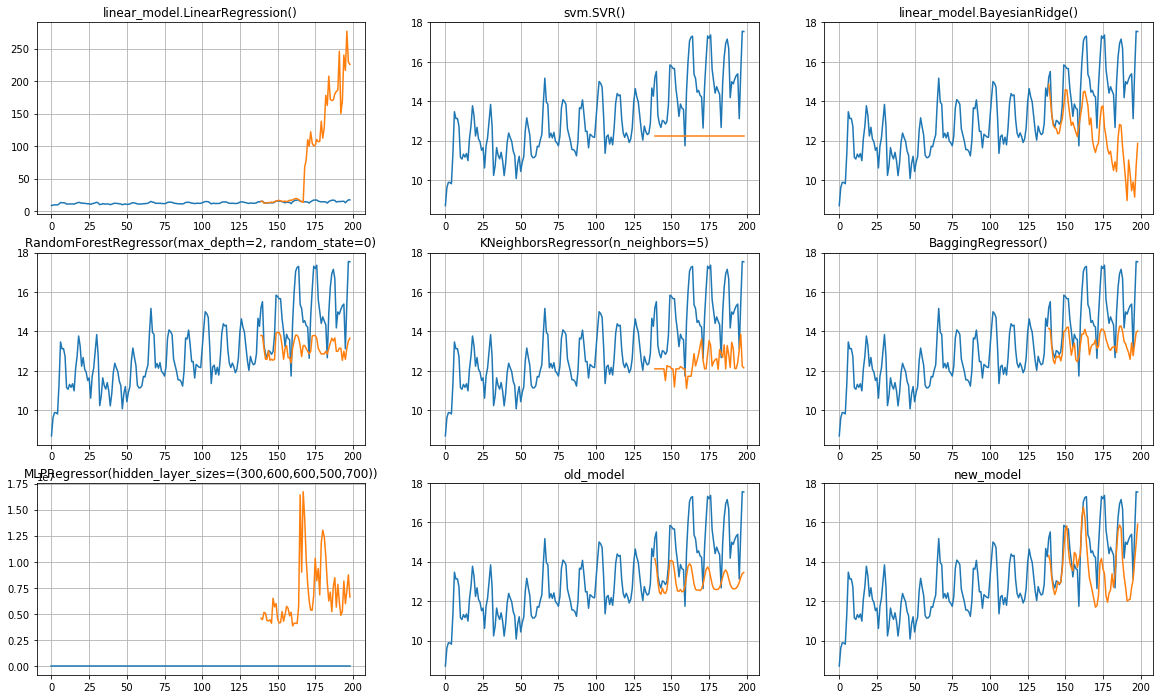

Number of samples in training data: 139
Number of samples in validation data: 60
(139, 96) (139,)
(60, 96) (60,)
Train RMSE: 0.23645742249623783
Test RMSE: 212230020.33236754
Train RMSE: 0.5252314972294786
Test RMSE: 2.1429391114837766
Train RMSE: 0.332659639502976
Test RMSE: 2.185945997946806
Train RMSE: 0.5526908322466135
Test RMSE: 2.08204168717213
Train RMSE: 0.45900370689329234
Test RMSE: 2.138536227283454
Train RMSE: 0.2521825021682485
Test RMSE: 1.8093661129889167
Train RMSE: 1.1491343563101155
Test RMSE: 2.2978771058681624
Dataframe used (EPP_array index): 1


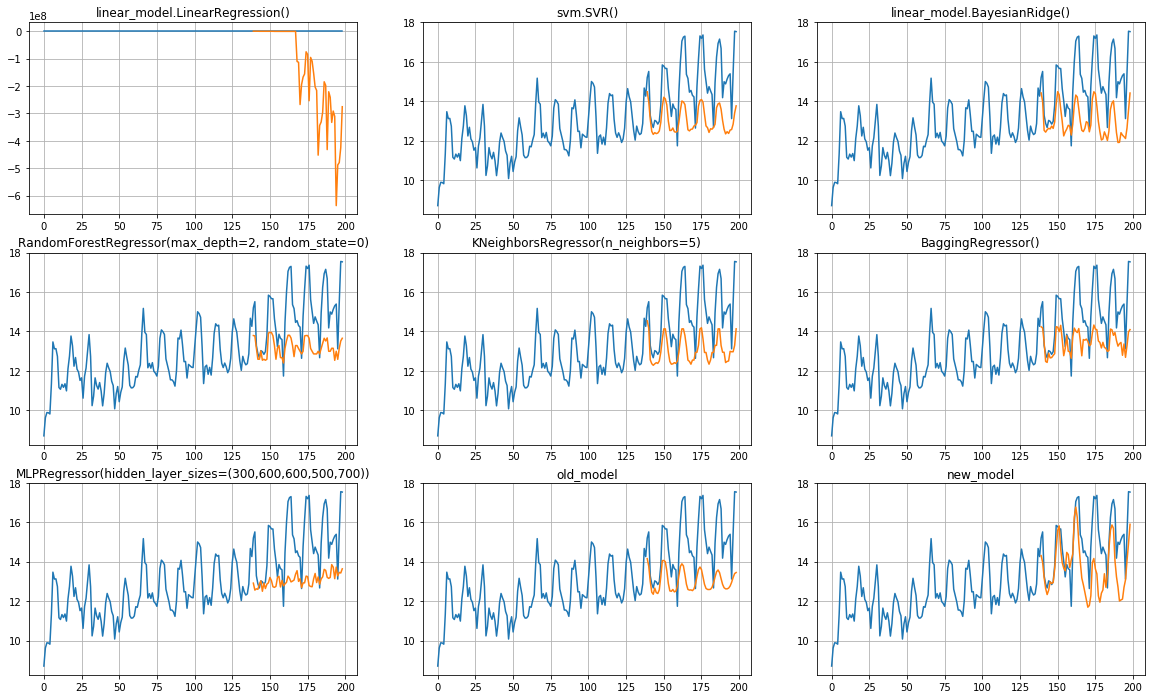

Number of samples in training data: 79
Number of samples in validation data: 60
(79, 52) (79,)
(60, 52) (60,)
Train RMSE: 0.011990254365400462
Test RMSE: 0.2075322211159684
Train RMSE: 0.6142560256667492
Test RMSE: 1.6301507664433619
Train RMSE: 0.026119199236808558
Test RMSE: 0.21045734150625045
Train RMSE: 0.38203759492308453
Test RMSE: 0.5169651517840083
Train RMSE: 0.4838185255497538
Test RMSE: 0.7178469552235176
Train RMSE: 0.1531887489503031
Test RMSE: 0.3309441750341784
Train RMSE: 0.8960101005231951
Test RMSE: 7.077337490056513
Dataframe used (EPP_array index): 2


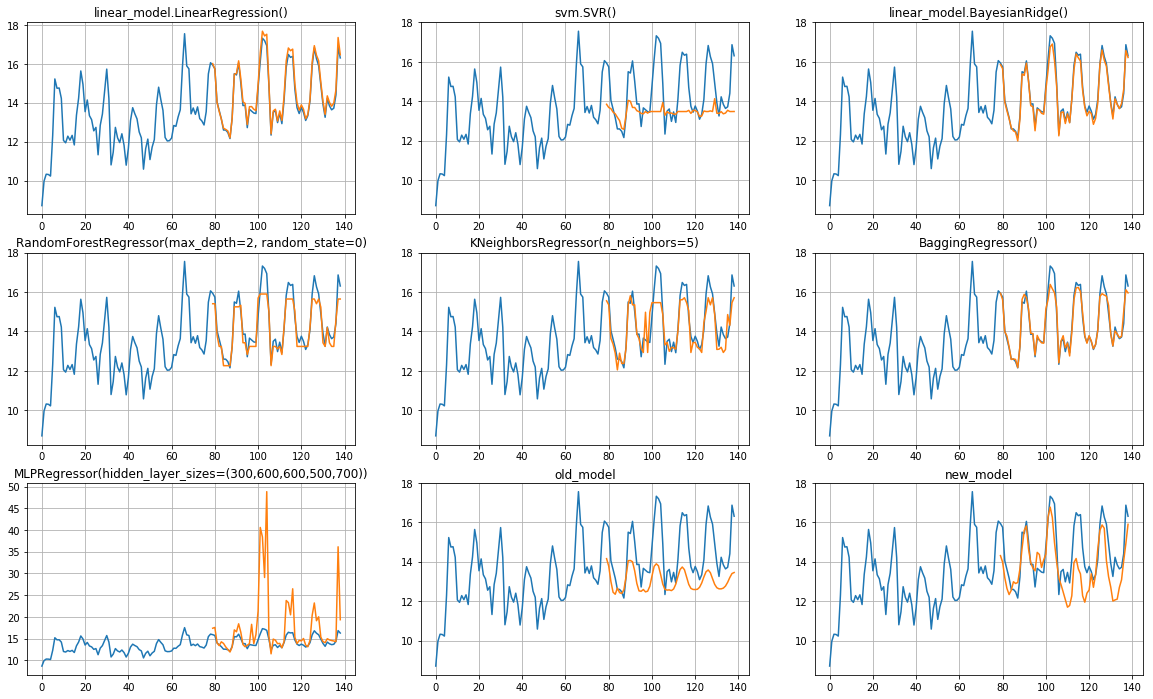

Number of samples in training data: 19
Number of samples in validation data: 60
(19, 3180) (19,)
(60, 3180) (60,)
Train RMSE: 5.5578891936286705e-15
Test RMSE: 1.472340233043864
Train RMSE: 0.8337514855517866
Test RMSE: 1.5459817870831485
Train RMSE: 2.625243542423518e-06
Test RMSE: 1.612865989543708
Train RMSE: 0.45343995373797835
Test RMSE: 0.9193954012910167
Train RMSE: 0.5490062753103189
Test RMSE: 0.7241266498473877
Train RMSE: 0.33711036139271894
Test RMSE: 0.711998450697297
Train RMSE: 1.4934037249622043
Test RMSE: 3.870695275459208
Dataframe used (EPP_array index): 3


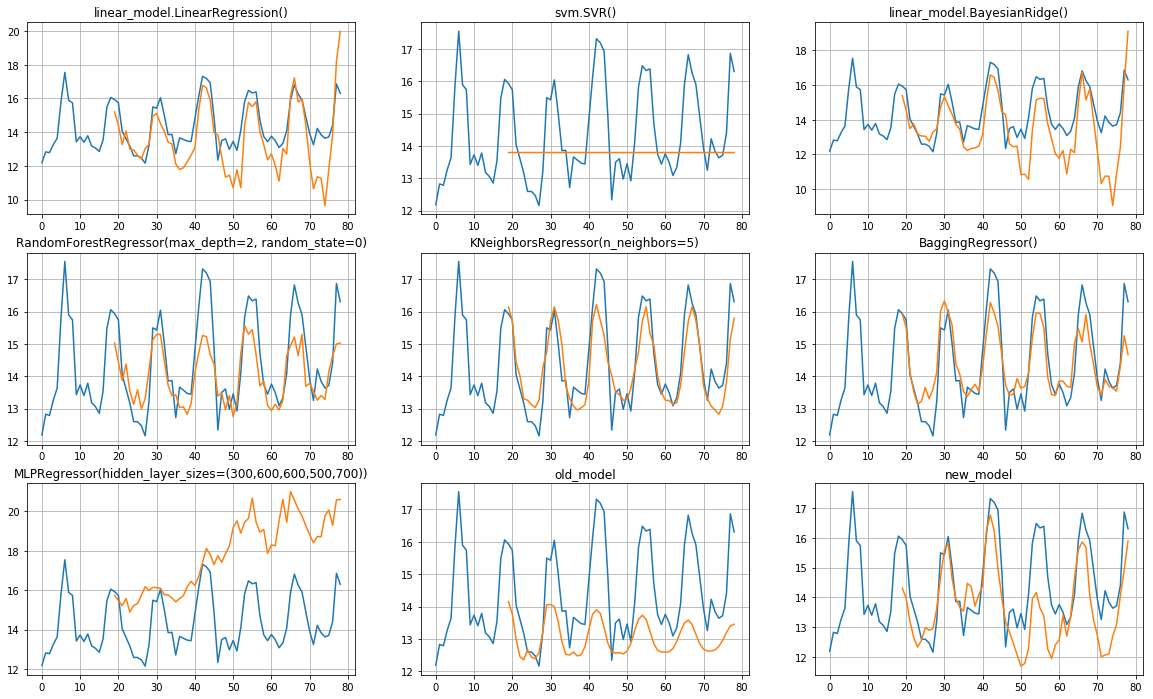

Number of samples in training data: 20
Number of samples in validation data: 60
(20, 5820) (20,)
(60, 5820) (60,)
Train RMSE: 2.9188521333542966e-15
Test RMSE: 1.9615328820605964
Train RMSE: 0.6039231071798605
Test RMSE: 2.3903701098924834
Train RMSE: 4.664797988637395e-06
Test RMSE: 1.961155501854526
Train RMSE: 0.2552547213339057
Test RMSE: 1.9778850275788242
Train RMSE: 0.3091637108004028
Test RMSE: 2.0679399886090666
Train RMSE: 0.16786735849656653
Test RMSE: 1.6184313178765766
Train RMSE: 1.5659120196945342
Test RMSE: 2.8355924530847587
Dataframe used (EPP_array index): 4


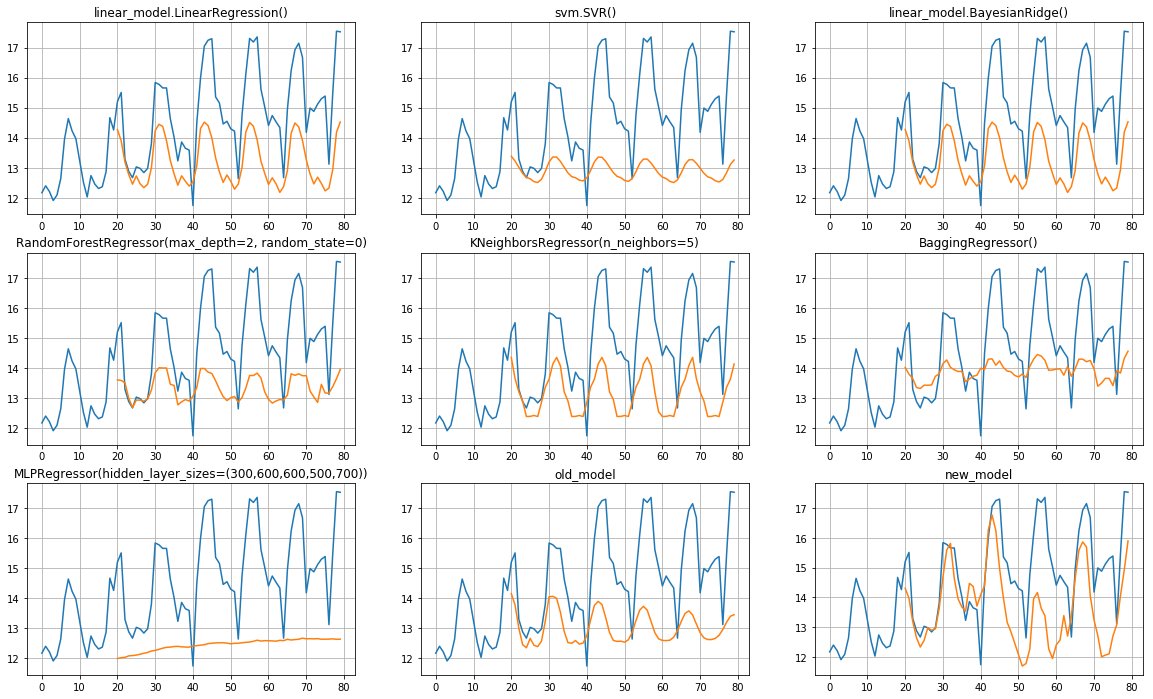

Number of samples in training data: 103
Number of samples in validation data: 60
(103, 58) (103,)
(60, 58) (60,)
Train RMSE: 0.0017087198202198714
Test RMSE: 0.0226997025569626
Train RMSE: 0.3087589137842207
Test RMSE: 1.450548459157666
Train RMSE: 0.003515180505787134
Test RMSE: 0.0922512759083477
Train RMSE: 0.2002552918623026
Test RMSE: 0.5845220091833158
Train RMSE: 0.1481471015284499
Test RMSE: 0.5024757026350575
Train RMSE: 0.04776389031583171
Test RMSE: 0.3775620719189395
Train RMSE: 3.5217212492778223
Test RMSE: 7.473443904845593
Dataframe used (EPP_array index): 5


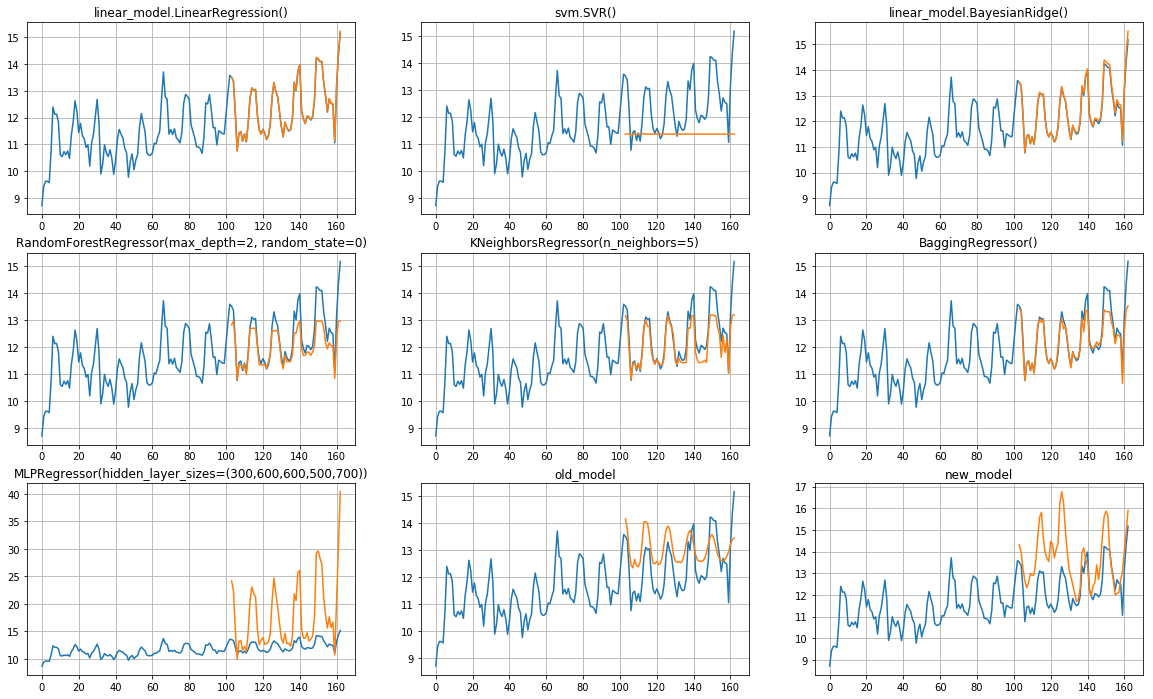

Number of samples in training data: 79
Number of samples in validation data: 60
(79, 10) (79,)
(60, 10) (60,)
Train RMSE: 0.0351234630896949
Test RMSE: 0.051785619047008936
Train RMSE: 0.38957825436192733
Test RMSE: 0.682940745699887
Train RMSE: 0.035276747050754
Test RMSE: 0.05345933828901054
Train RMSE: 0.3798354100078783
Test RMSE: 0.5016487594141609
Train RMSE: 0.5603634771373609
Test RMSE: 0.7870415917256947
Train RMSE: 0.11982205966410511
Test RMSE: 0.22056567503729746
Train RMSE: 4.862042313248251
Test RMSE: 6.160530617783607
Dataframe used (EPP_array index): 6


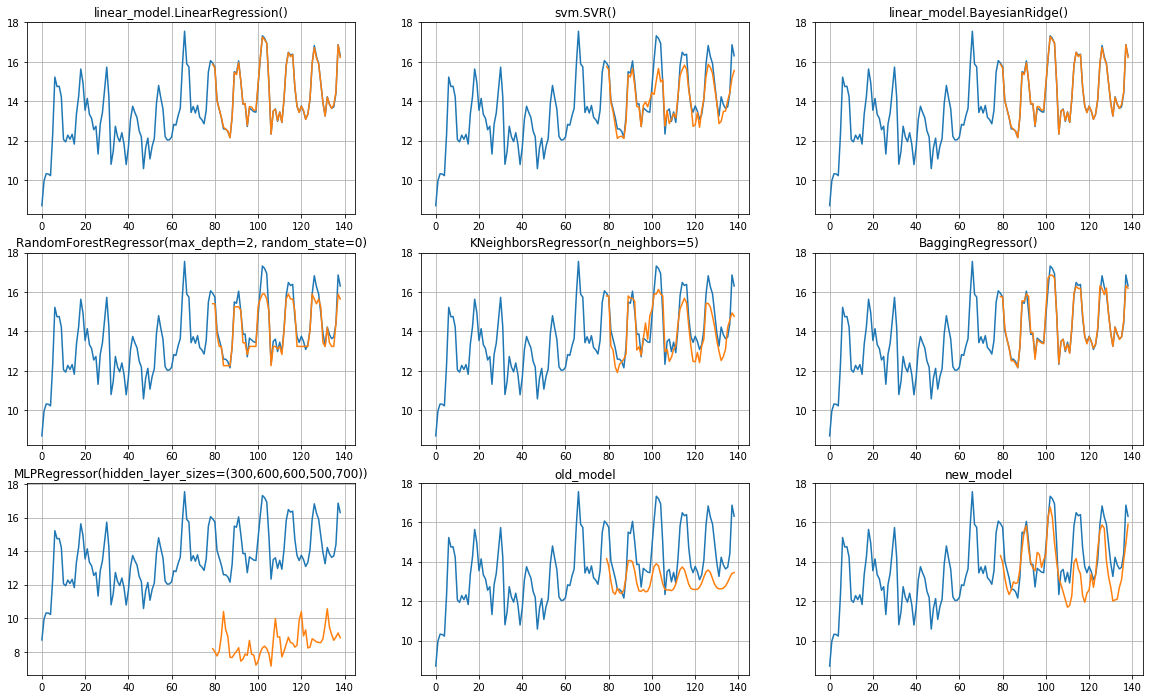

Number of samples in training data: 79
Number of samples in validation data: 60
(79, 25) (79,)
(60, 25) (60,)
Train RMSE: 0.021882250325656417
Test RMSE: 0.07864878330070382
Train RMSE: 0.5414521505672203
Test RMSE: 1.3984577302412586
Train RMSE: 0.02270856054636267
Test RMSE: 0.0838307661619359
Train RMSE: 0.37533723340030556
Test RMSE: 0.5115632878543434
Train RMSE: 0.42750097340156623
Test RMSE: 0.6546648930949394
Train RMSE: 0.11459616889482363
Test RMSE: 0.18855456737708856
Train RMSE: 4.6514873319565835
Test RMSE: 4.516708701275584
Dataframe used (EPP_array index): 7


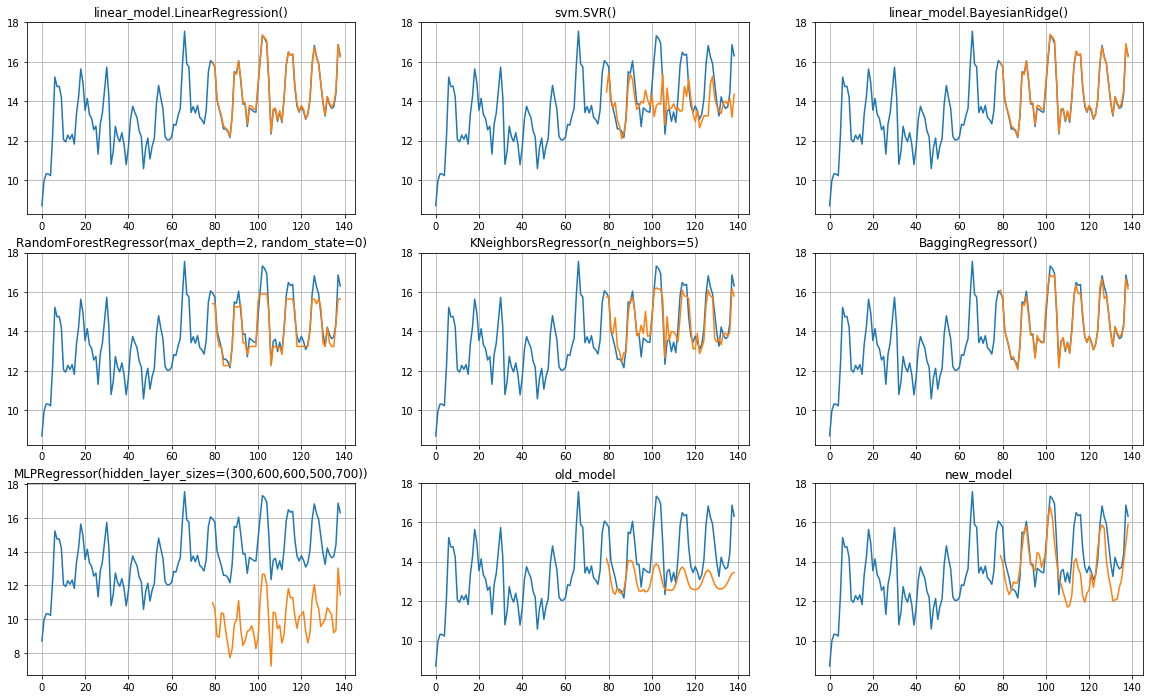

Number of samples in training data: 79
Number of samples in validation data: 60
(79, 40) (79,)
(60, 40) (60,)
Train RMSE: 0.017918266394606027
Test RMSE: 0.13847797515669064
Train RMSE: 0.5398579588580353
Test RMSE: 1.3673025230150924
Train RMSE: 0.035230494738567486
Test RMSE: 0.3113214499918724
Train RMSE: 0.3841224867911976
Test RMSE: 0.5169651517840085
Train RMSE: 0.4487828481379291
Test RMSE: 0.6940729065117198
Train RMSE: 0.1844441928582913
Test RMSE: 0.22827283974158422
Train RMSE: 1.6130507697527
Test RMSE: 1.8853347119603996
Dataframe used (EPP_array index): 8


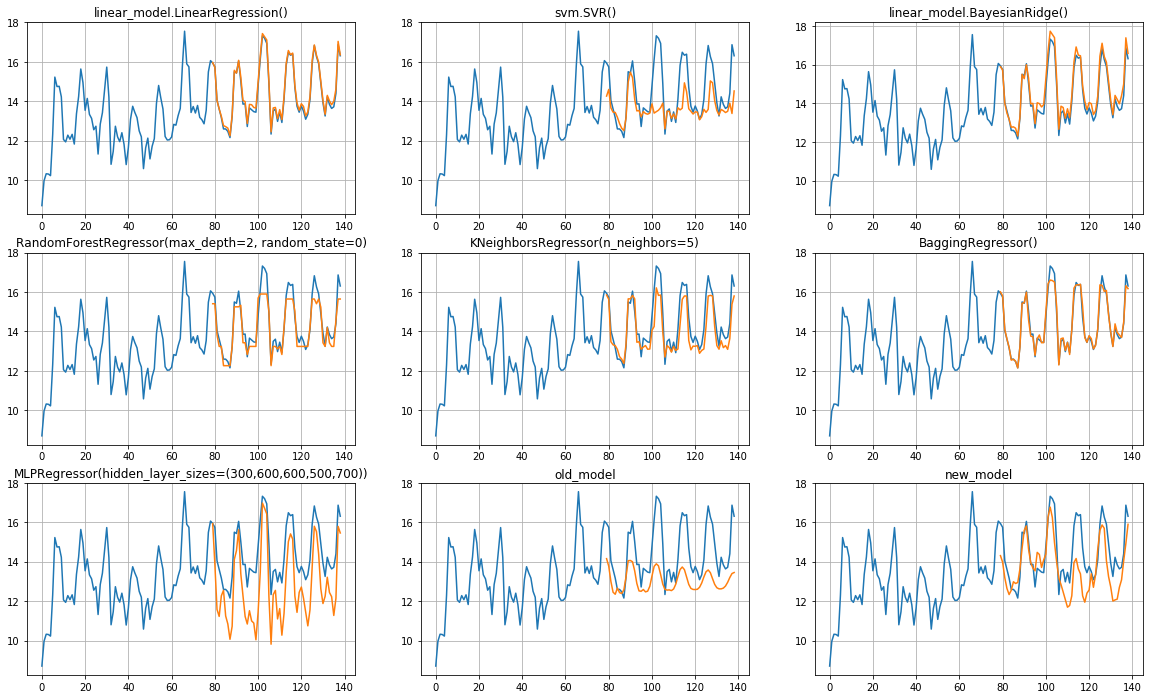

Number of samples in training data: 61
Number of samples in validation data: 60
(61, 2) (61,)
(60, 2) (60,)
Train RMSE: 0.2346920152068935
Test RMSE: 0.18870189448745173
Train RMSE: 0.46457355322851535
Test RMSE: 1.7429326168715253
Train RMSE: 0.23469784833994017
Test RMSE: 0.18832583669838568
Train RMSE: 0.40416645423486197
Test RMSE: 0.9541059912422921
Train RMSE: 0.3000907529967525
Test RMSE: 0.6694597751015072
Train RMSE: 0.16219885139777615
Test RMSE: 0.5376729600124879
Train RMSE: 4.274444881619156
Test RMSE: 7.049195105651251
Dataframe used (EPP_array index): 9


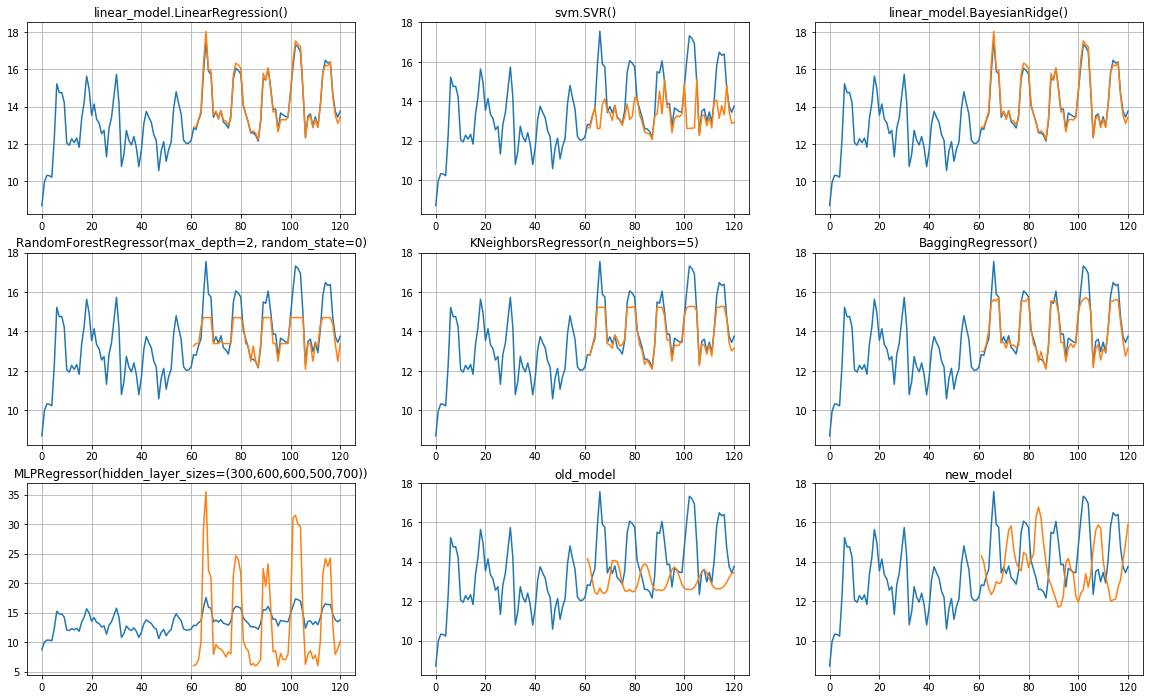

Number of samples in training data: 61
Number of samples in validation data: 60
(61, 15) (61,)
(60, 15) (60,)
Train RMSE: 0.02093317380778884
Test RMSE: 0.7371390074074623
Train RMSE: 0.25546580327107204
Test RMSE: 1.238301183577818
Train RMSE: 0.02134363219274247
Test RMSE: 0.6580083991552168
Train RMSE: 0.404166454234862
Test RMSE: 0.9541059912422921
Train RMSE: 0.28648876415069185
Test RMSE: 0.7396836686524468
Train RMSE: 0.17761582972342563
Test RMSE: 0.7793522320189904
Train RMSE: 3.54301192589947
Test RMSE: 8.330790376756557
Dataframe used (EPP_array index): 10


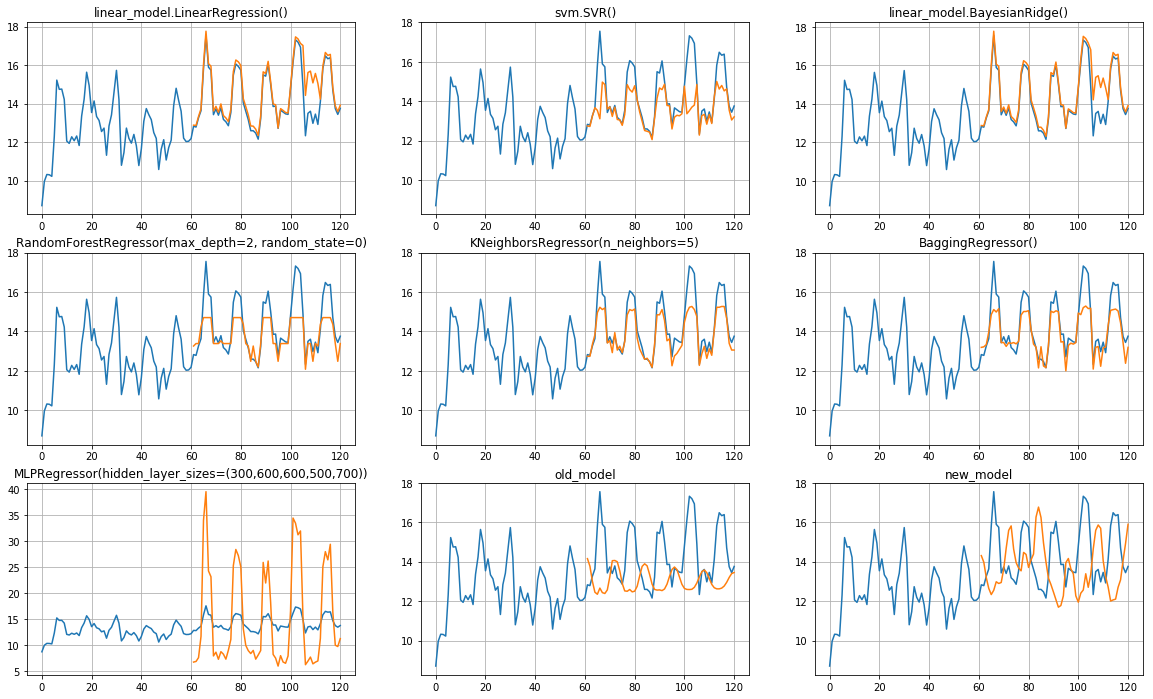

Number of samples in training data: 61
Number of samples in validation data: 60
(61, 20) (61,)
(60, 20) (60,)
Train RMSE: 1.9347653850350873e-09
Test RMSE: 1.0464563978600447
Train RMSE: 0.24019350818701746
Test RMSE: 1.1289969098598105
Train RMSE: 1.0696523984745841e-06
Test RMSE: 1.0463791158658
Train RMSE: 0.4041664542348618
Test RMSE: 0.9541059912422921
Train RMSE: 0.28648876415069185
Test RMSE: 0.7389162830273877
Train RMSE: 0.21459612879293113
Test RMSE: 0.7863744422106844
Train RMSE: 3.5045329727202925
Test RMSE: 8.293035725874724
Dataframe used (EPP_array index): 11


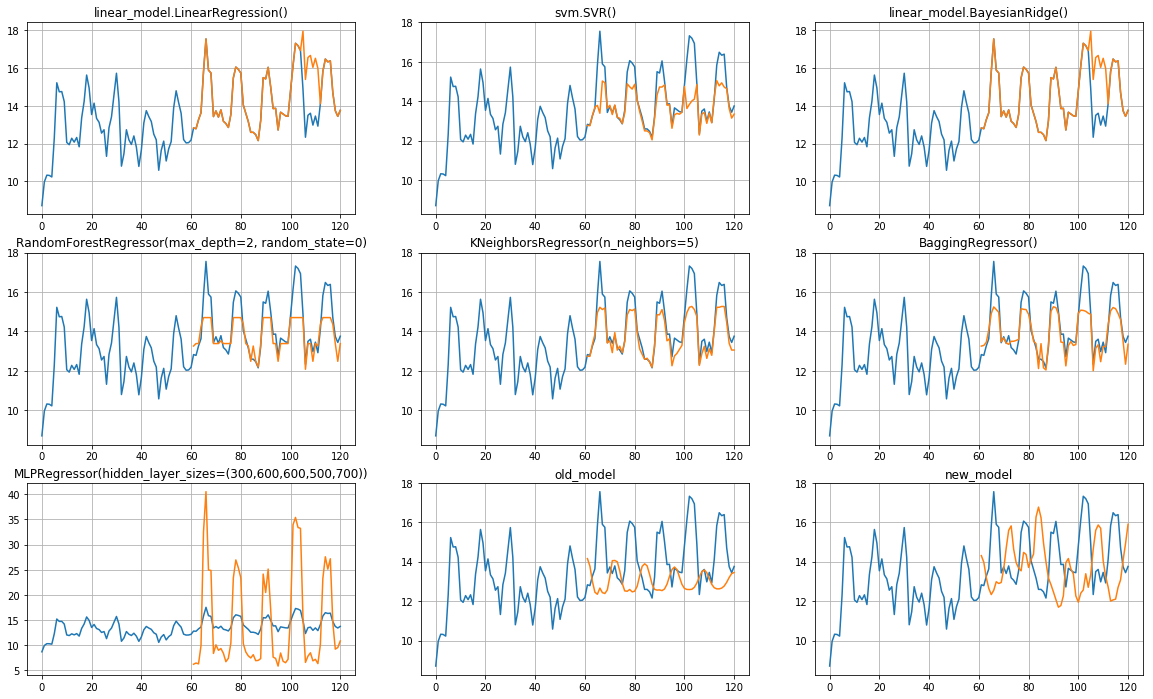

Number of samples in training data: 139
Number of samples in validation data: 60
(139, 12) (139,)
(60, 12) (60,)
Train RMSE: 0.6180320428454332
Test RMSE: 6.391357832589285
Train RMSE: 0.5953795847353018
Test RMSE: 3.056966772761636
Train RMSE: 0.6750603159276044
Test RMSE: 1.2937036522705776
Train RMSE: 0.601460433647297
Test RMSE: 1.884186401956544
Train RMSE: 0.6000143643364482
Test RMSE: 1.7100152046107662
Train RMSE: 0.296197581344353
Test RMSE: 2.399011480450507
Train RMSE: 111.57550604127321
Test RMSE: 173.6751669873898
Dataframe used (EPP_array index): 12


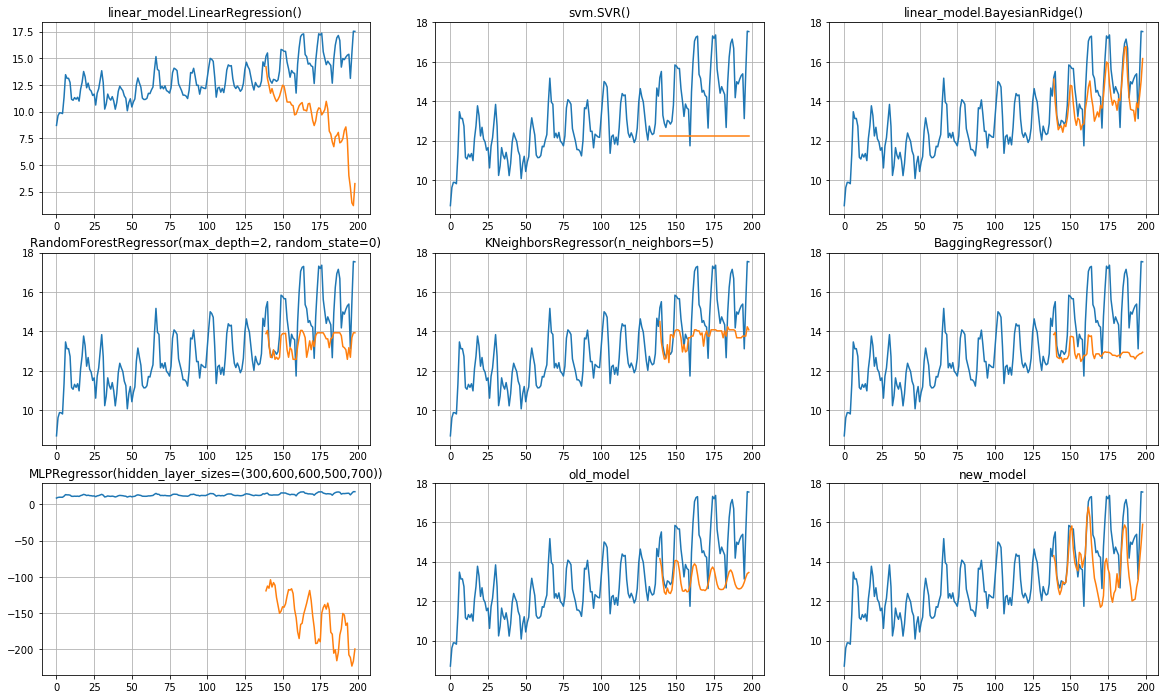

Number of samples in training data: 139
Number of samples in validation data: 60
(139, 4) (139,)
(60, 4) (60,)
Train RMSE: 0.8529694885533571
Test RMSE: 7.599352903645795
Train RMSE: 0.6903700251206344
Test RMSE: 3.0259050248962254
Train RMSE: 0.8812762019887037
Test RMSE: 1.3979502949914884
Train RMSE: 0.8026778465846071
Test RMSE: 2.4471013722933823
Train RMSE: 0.8131116358619527
Test RMSE: 2.7692144132707868
Train RMSE: 0.3350003758185371
Test RMSE: 2.5652983452222475
Train RMSE: 3.116840495932942
Test RMSE: 3.2981531048379478
Dataframe used (EPP_array index): 13


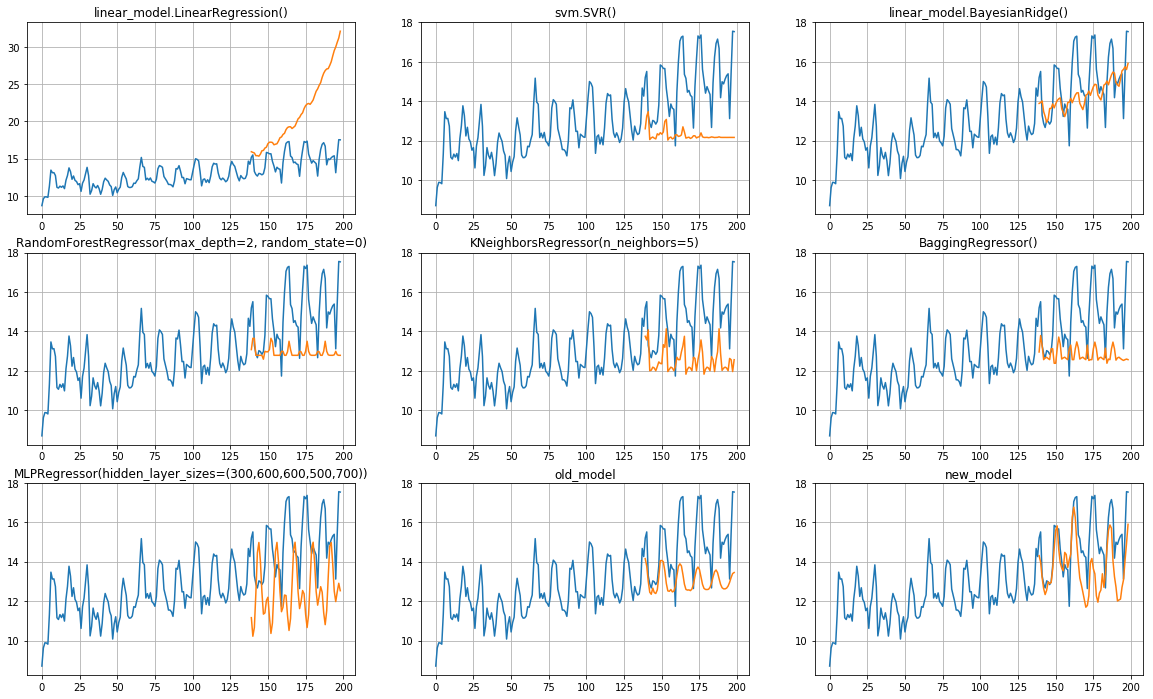

In [147]:
#import all the libraries
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.neural_network import MLPRegressor

#establish the docket, insert the function for any desired model for testing. Plotter can only accommodate 9 models in the grid
docket = ['linear_model.LinearRegression()','svm.SVR()',
         'linear_model.BayesianRidge()','RandomForestRegressor(max_depth=2, random_state=0)',
         'KNeighborsRegressor(n_neighbors=5)','BaggingRegressor()',
         'MLPRegressor(hidden_layer_sizes=(300,600,600,500,700))','old_model',
         'new_model']

#for all EPPdfs, for all models, define regs and execute
#for each model store the RMSEs and plot as a timeseries
for dat in range(len(EPP_array)):
    EPPdf = EPP_array[dat]
    X_train, X_val, Y_train, Y_val = tt_split(EPPdf,test_months=60,split_type="sequence",comp_var='Price')

    
    f = plt.figure(figsize=(20,12))
    # Specify the grid
    ax0 = plt.subplot2grid((3,3), (0,0)) 
    ax1 = plt.subplot2grid((3,3), (0,1)) 
    ax2 = plt.subplot2grid((3,3), (0,2))
    ax3 = plt.subplot2grid((3,3), (1,0))
    ax4 = plt.subplot2grid((3,3), (1,1))
    ax5 = plt.subplot2grid((3,3), (1,2))
    ax6 = plt.subplot2grid((3,3), (2,0))
    ax7 = plt.subplot2grid((3,3), (2,1))
    ax8 = plt.subplot2grid((3,3), (2,2))
        
    for mod in range(len(docket)):
        if docket[mod] == 'old_model':
            #plot the old 1 feature price projection model
            exec('ax'+str(mod)+'.plot(range(len(EPPdf)), EPPdf.Price)')
            exec('ax'+str(mod)+'.plot(range(len(EPPdf)-start_back, len(EPPdf)+pred_len-start_back),predictions[-60:], 'r')')
            #exec('ax'+str(mod)+'.plot(range(len(std_all_data)-start_back, len(std_all_data)+pred_len-start_back),predictions[-60:], 'r')')
            exec('ax'+str(mod)+'.set_title(docket[mod])')
            #exec('ax'+str(mod)+'.ylim([12,20])')
            #exec('ax'+str(mod)+'.xlim([len(std_all_data)-len(preds), len(std_all_data)])')
            exec('ax'+str(mod)+'.grid()')
        
        
        elif docket[mod] == 'new_model':
            #plot the new model
            exec('ax'+str(mod)+'.plot(range(len(EPPdf)), EPPdf.Price)')
            exec('ax'+str(mod)+'.plot(range(len(EPPdf)-start_back, len(EPPdf)+pred_len-start_back),preds, 'r')')
            #exec('ax'+str(mod)+'.plot(range(len(std_all_data)-start_back, len(std_all_data)+pred_len-start_back),[pred for pred in preds])')
            exec('ax'+str(mod)+'.set_title(docket[mod])')
            #exec('ax'+str(mod)+'.ylim([12,20])')
            #exec('ax'+str(mod)+'.xlim([len(std_all_data)-len(preds), len(std_all_data)])')
            exec('ax'+str(mod)+'.grid()')
        else:
            exec('reg = '+docket[mod])
            reg.fit(X_train, Y_train)
            Y_pred = reg.predict(X_val) # predict


            # The mean squared error
            Y_pred_train = reg.predict(X_train) # validate
            TrainAllData = sqrt(mean_squared_error(Y_train, Y_pred_train))
            TestAllData = sqrt(mean_squared_error(Y_val, Y_pred))

            print("Train RMSE:",TrainAllData)
            print("Test RMSE:",TestAllData)
        
            RMSE_df[docket[mod]+'_dataset_'+str(dat)] =  [TrainAllData,TestAllData]
            
            #plot the docket models
            exec('ax'+str(mod)+'.plot(range(len(EPPdf)), EPPdf.Price)')
            exec('ax'+str(mod)+'.plot(range(len(EPPdf)-start_back, len(EPPdf)+pred_len-start_back),Y_pred, 'r')')
            exec('ax'+str(mod)+'.set_title(docket[mod])')
            exec('ax'+str(mod)+'.grid()')        
    
    print("Dataframe used (EPP_array index):",dat)
    plt.show()

        

In [152]:
RMSE_df

new_model  old_1feat_method  linear_model.LinearRegression()_dataset_0  \
0   1.784616          0.511874                                   0.241261   
1   0.000000          2.229868                                 108.632533   

   svm.SVR()_dataset_0  linear_model.BayesianRidge()_dataset_0  \
0             0.595380                                0.573566   
1             3.056967                                3.159186   

   RandomForestRegressor(max_depth=2, random_state=0)_dataset_0  \
0                                           0.550988              
1                                           2.082042              

   KNeighborsRegressor(n_neighbors=5)_dataset_0  BaggingRegressor()_dataset_0  \
0                                      0.940825                      0.240159   
1                                      2.927543                      1.869135   

   MLPRegressor(hidden_layer_sizes=(300,600,600,500,700))_dataset_0  \
0                                       8.707055e+06                  
1                                       7.537489e+06                  

   linear_model.LinearRegression()_dataset_1  \
0                               2.364574e-01   
1                               2.122300e+08   

                                 ...                                  \
0                                ...                                   
1                                ...                                   

   KNeighborsRegressor(n_neighbors=5)_dataset_12  \
0                                       0.600014   
1                                       1.710015   

   BaggingRegressor()_dataset_12  \
0                       0.296198   
1                       2.399011   

   MLPRegressor(hidden_layer_sizes=(300,600,600,500,700))_dataset_12  \
0                                         111.575506                   
1                                         173.675167                   

   linear_model.LinearRegression()_dataset_13  svm.SVR()_dataset_13  \
0                                    0.852969              0.690370   
1                                    7.599353              3.025905   

   linear_model.BayesianRidge()_dataset_13  \
0                                 0.881276   
1                                 1.397950   

   RandomForestRegressor(max_depth=2, random_state=0)_dataset_13  \
0                                           0.802678               
1                                           2.447101               

   KNeighborsRegressor(n_neighbors=5)_dataset_13  \
0                                       0.813112   
1                                       2.769214   

   BaggingRegressor()_dataset_13  \
0                       0.335000   
1                       2.565298   

   MLPRegressor(hidden_layer_sizes=(300,600,600,500,700))_dataset_13  
0                                           3.116840                  
1                                           3.298153                  

[2 rows x 100 columns]

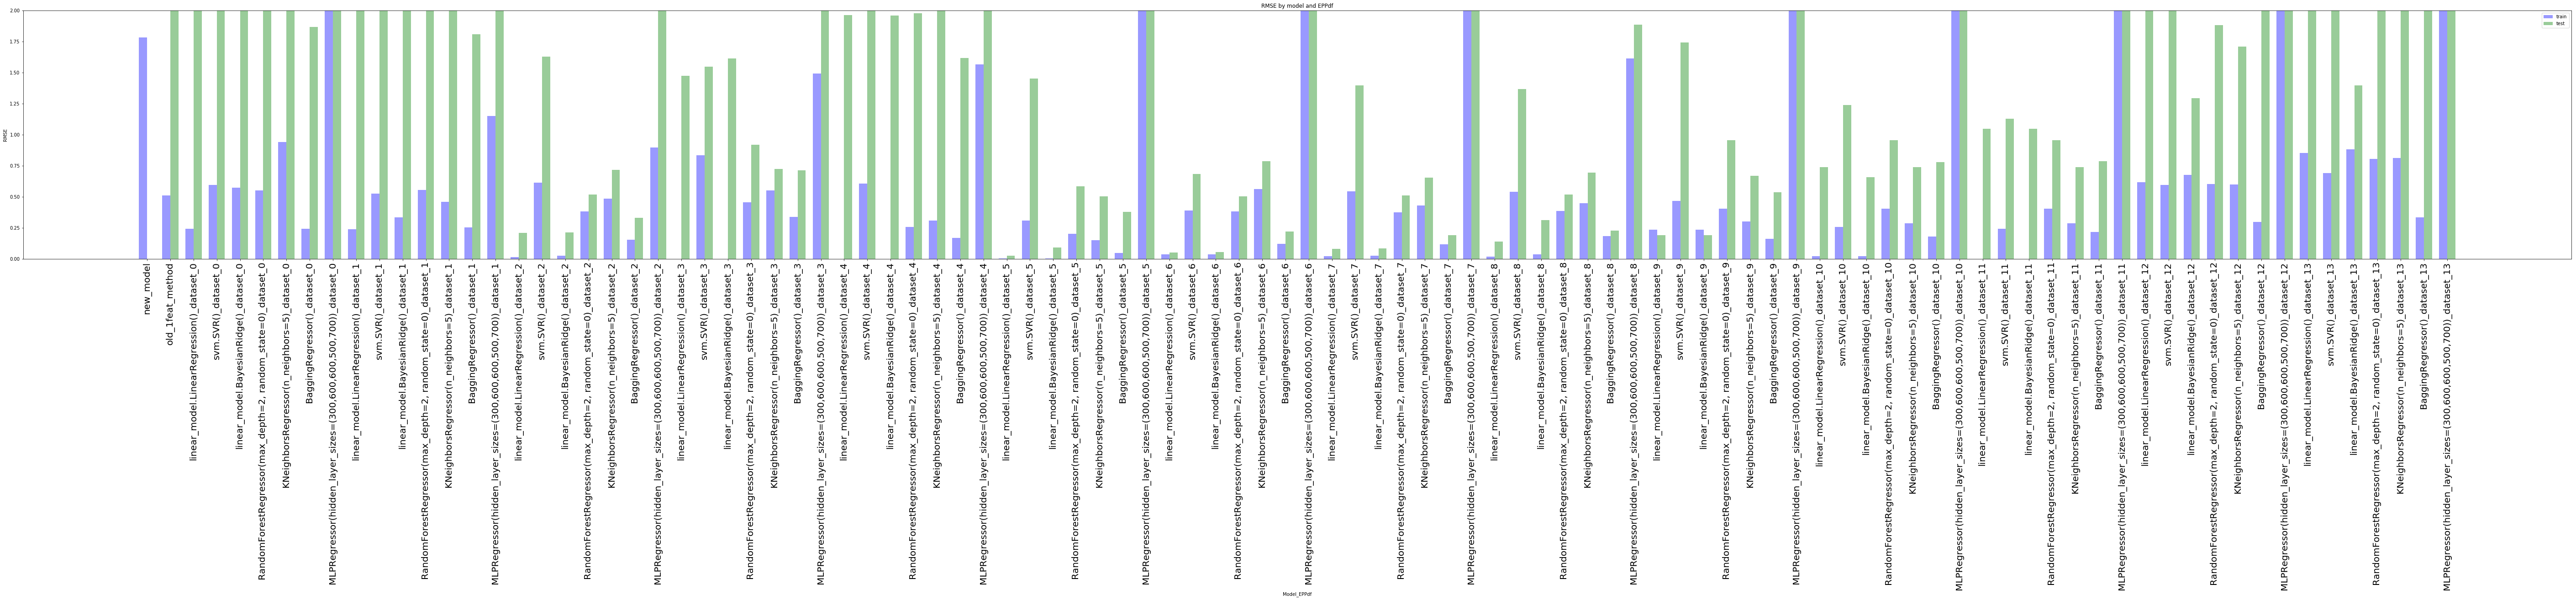

In [178]:
#Plot bar chart of train and test RMSE for each docket item and hopping lasso, make one plot for each EPPdf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple

fig, ax = plt.subplots(figsize=(100,10))

index = np.arange(len(list(RMSE_df)))
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, RMSE_df.iloc[0].values, bar_width,
                alpha=opacity, color='b',
                label='train')

rects2 = ax.bar(index + bar_width, RMSE_df.iloc[1].values, bar_width,
                alpha=opacity, color='green',
                label='test')


ax.set_xlabel('Model_EPPdf')
ax.set_ylabel('RMSE')
ax.set_title('RMSE by model and EPPdf')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(list(RMSE_df),rotation=90,fontsize = 20)
ax.legend()
ax.set_ylim([0, 2])

#fig.tight_layout()
plt.show()